# OMG Narwhals CTD L1 and L2 data processing
## Create NetCDFs for each profile

#### This notebook creates L1 and L2 datasets for L0 CTD profiles

In [1]:
## allows proper loading of external py scripts and functions
%load_ext autoreload
%autoreload 1

In [2]:
## import all necessary libraries
import string
import numpy as np
import glob 
import matplotlib.pyplot as plt
from pathlib import Path
from pprint import pprint
import xarray as xr
import netCDF4 as nc4
import pandas as pd
import os

## external, custom py script within same directory
import omgCTD_funs

## Create L2 CTD files

In [3]:
## get all metadata associated with each data file
# read in csv with metadata
metafile = Path("F:/PhD_chap3/metadata/CTD/CTD_metadata.csv")
metadata = pd.read_csv(metafile)

In [4]:
## Process profiles to netcdfs
# loop that takes cnv filenames from 3 directories according to year (2018, 2019, 2020) and then creates netCDFs for each file
# output nc files are saved in appropriate L2 folder according to year

dirs = ("F:/PhD_chap3/data/OMG_Narwhals_CTD_data/OMG_Narwhals_CTD_L0/2018/cnv/",
        "F:/PhD_chap3/data/OMG_Narwhals_CTD_data/OMG_Narwhals_CTD_L0/2019/cnv/",
        "F:/PhD_chap3/data/OMG_Narwhals_CTD_data/OMG_Narwhals_CTD_L0/2020/cnv/")

for directory in dirs:
    os.chdir(directory)
    cnvfiles = []
    for file in glob.glob("*.cnv"):
        cnvfiles.append(file)
    pprint(cnvfiles)
    for filename in cnvfiles:
        data = metadata.loc[metadata['filename_L0'] == filename] # select row for cnv file 'filename'
        lat = data.lat.values[0]
        lon = data.lon.values[0]
        start_time_log = data.start_time.values[0] # this is start time from excel log
        start_day = data.Day.values[0]
        start_year = data.Year.values[0]
        cast_id = data.cast_id.values[0]
        seafloor_depth = str(data.seafloor_depth.values[0]) + ' m'
        cast_depth = str(data.cast_depth.values[0]) + ' m'
        
        file = Path(directory + filename)
        uuid = data.uuid_L2.values[0]
        
        ## extract data, create dataset, and add metadata
        netcdf_filename, start_time_filename, data_lines, start_time_dt64, end_time, sample_interval_iso, var_names = omgCTD_funs.open_omg_file(file, start_year, start_day, start_time_log)
        ctd_profile_ds = omgCTD_funs.create_Dataset(data_lines, start_time_dt64, lat, lon, netcdf_filename)
        ctd_profile_ds = omgCTD_funs.add_metadata(ctd_profile_ds, uuid, seafloor_depth, cast_depth, cast_id, netcdf_filename, sample_interval_iso, end_time)
        
        ## print dataset
        with xr.set_options(display_style="html"):
            display(ctd_profile_ds)
        
        ## Create NetCDF variable encoding (required to save the time values properly)
        new_encoding = omgCTD_funs.create_encoding(ctd_profile_ds)
        
        if '2018' in netcdf_filename:
            output_dir = Path(directory[:-11] + "2/2018")
        elif '2019' in netcdf_filename:
            output_dir = Path(directory[:-11] + "2/2019")
        elif '2020' in netcdf_filename:
            output_dir = Path(directory[:-11] + "2/2020")
        
        ctd_profile_ds.to_netcdf(output_dir / netcdf_filename,encoding=new_encoding)
        ctd_profile_ds.close()

['SBE19plus_01906981_2018_08_27_0105.cnv',
 'SBE19plus_01906981_2018_08_27_0106.cnv',
 'SBE19plus_01906981_2018_08_27_0107.cnv',
 'SBE19plus_01906981_2018_08_27_0108.cnv',
 'SBE19plus_01906981_2018_08_27_0109.cnv',
 'SBE19plus_01906981_2018_08_27_0110.cnv',
 'SBE19plus_01906981_2018_08_27_0111.cnv',
 'SBE19plus_01906981_2018_08_27_0112.cnv']
number data lines 5065
number header lines 524
2018-08-23T00:55:11
2018-08-23T00:55:11
OMG_Narwhals_Ocean_CTD_L2_20180823005511.nc


<xarray.Dataset>
Dimensions:                (depth: 5065, profile: 1)
Coordinates:
  * depth                  (depth) object -33.516 -33.534 ... 334.2 334.224
    depth_correction       (depth) object -0.5159999999999982 ... 367.224
    latitude               (profile) float64 75.54
    longitude              (profile) float64 -58.42
    time                   (profile) datetime64[ns] 2018-08-23T00:55:11
Dimensions without coordinates: profile
Data variables:
    pressure               (depth) object -33.865 -33.884 ... 337.984 338.008
    temperature            (depth) object 13.7487 13.7352 ... 1.332 1.3317
    conductivity           (depth) object 0.010013 0.00991 ... 2.973061 2.973101
    salinity               (depth) object 0.0621 0.0615 ... 34.2142 34.215
    sound_velocity         (depth) object 1461.02 1460.97 ... 1459.63 1459.63
    density                (depth) object 999.1699 999.1711 ... 1028.9857
    potential_temperature  (depth) object 13.7519 13.7385 ... 1.3156 1.3153
Attributes: (12/55)
    title:                         OMG Narwhals Ocean CTD Level 2 Data
    summary:                       This dataset contains conductivity, temper...
    Conventions:                   CF-1.8, ACDD-1.3
    keywords:                      Conductivity, Salinity, Water Depth, Water...
    keywords_vocabulary:           NASA Global Change Master Directory (GCMD)...
    standard_name_vocabulary:      NetCDF Climate and Forecast (CF) Metadata ...
    ...                            ...
    geospatial_vertical_positive:  down
    time_coverage_resolution:      P0.25S
    time_coverage_start:           2018-08-23T00:55:11
    time_coverage_end:             2018-08-23T01
    time_coverage_duration:        P0DT0H21M6S
    date_created:                  2023-09-12T15:57:04

number data lines 5358
number header lines 524
2018-08-23T12:04:27
2018-08-23T12:04:27
OMG_Narwhals_Ocean_CTD_L2_20180823120427.nc


<xarray.Dataset>
Dimensions:                (depth: 5358, profile: 1)
Coordinates:
  * depth                  (depth) object -33.139 -33.139 ... 449.051 449.057
    depth_correction       (depth) object -0.1390000000000029 ... 482.057
    latitude               (profile) float64 75.48
    longitude              (profile) float64 -58.47
    time                   (profile) datetime64[ns] 2018-08-23T12:04:27
Dimensions without coordinates: profile
Data variables:
    pressure               (depth) object -33.484 -33.484 ... 454.263 454.269
    temperature            (depth) object 5.0303 5.0291 5.0274 ... 1.8734 1.8734
    conductivity           (depth) object 0.004672 0.004618 ... 3.044971
    salinity               (depth) object 0.0345 0.0341 ... 34.4683 34.468
    sound_velocity         (depth) object 1425.82 1425.82 ... 1464.27 1464.27
    density                (depth) object 999.8294 999.8291 ... 1029.6869
    potential_temperature  (depth) object 5.031 5.0297 5.028 ... 1.8486 1.8486
Attributes: (12/55)
    title:                         OMG Narwhals Ocean CTD Level 2 Data
    summary:                       This dataset contains conductivity, temper...
    Conventions:                   CF-1.8, ACDD-1.3
    keywords:                      Conductivity, Salinity, Water Depth, Water...
    keywords_vocabulary:           NASA Global Change Master Directory (GCMD)...
    standard_name_vocabulary:      NetCDF Climate and Forecast (CF) Metadata ...
    ...                            ...
    geospatial_vertical_positive:  down
    time_coverage_resolution:      P0.25S
    time_coverage_start:           2018-08-23T12:04:27
    time_coverage_end:             2018-08-23T12
    time_coverage_duration:        P0DT0H22M19.25S
    date_created:                  2023-09-12T15:57:10

number data lines 4909
number header lines 524
2018-08-23T16:36:10
2018-08-23T16:36:10
OMG_Narwhals_Ocean_CTD_L2_20180823163610.nc


<xarray.Dataset>
Dimensions:                (depth: 4909, profile: 1)
Coordinates:
  * depth                  (depth) object -33.255 -33.255 ... 381.22 381.22
    depth_correction       (depth) object -0.25500000000000256 ... 414.22
    latitude               (profile) float64 75.36
    longitude              (profile) float64 -58.86
    time                   (profile) datetime64[ns] 2018-08-23T16:36:10
Dimensions without coordinates: profile
Data variables:
    pressure               (depth) object -33.601 -33.601 ... 385.581 385.581
    temperature            (depth) object 8.0846 8.0747 8.065 ... 1.7092 1.7095
    conductivity           (depth) object 0.008024 0.008394 ... 3.019961
    salinity               (depth) object 0.0559 0.0585 ... 34.3698 34.3703
    sound_velocity         (depth) object 1439.03 1438.99 ... 1462.29 1462.29
    density                (depth) object 999.7278 999.7304 ... 1029.3021
    potential_temperature  (depth) object 8.0861 8.0762 8.0666 ... 1.689 1.6893
Attributes: (12/55)
    title:                         OMG Narwhals Ocean CTD Level 2 Data
    summary:                       This dataset contains conductivity, temper...
    Conventions:                   CF-1.8, ACDD-1.3
    keywords:                      Conductivity, Salinity, Water Depth, Water...
    keywords_vocabulary:           NASA Global Change Master Directory (GCMD)...
    standard_name_vocabulary:      NetCDF Climate and Forecast (CF) Metadata ...
    ...                            ...
    geospatial_vertical_positive:  down
    time_coverage_resolution:      P0.25S
    time_coverage_start:           2018-08-23T16:36:10
    time_coverage_end:             2018-08-23T16
    time_coverage_duration:        P0DT0H20M27S
    date_created:                  2023-09-12T15:57:10

number data lines 7477
number header lines 524
2018-08-24T11:33:38
2018-08-24T11:33:38
OMG_Narwhals_Ocean_CTD_L2_20180824113338.nc


<xarray.Dataset>
Dimensions:                (depth: 7477, profile: 1)
Coordinates:
  * depth                  (depth) object -33.527 -33.515 ... 259.697 259.715
    depth_correction       (depth) object -0.527000000000001 ... 292.715
    latitude               (profile) float64 75.79
    longitude              (profile) float64 -59.84
    time                   (profile) datetime64[ns] 2018-08-24T11:33:38
Dimensions without coordinates: profile
Data variables:
    pressure               (depth) object -33.876 -33.864 ... 262.59 262.608
    temperature            (depth) object 15.4243 15.3999 ... 1.1249 1.1256
    conductivity           (depth) object 0.023565 0.02269 ... 2.945512 2.945512
    salinity               (depth) object 0.1391 0.134 ... 34.1315 34.1308
    sound_velocity         (depth) object 1467.04 1466.95 ... 1457.36 1457.36
    density                (depth) object 998.9859 998.9858 ... 1028.5792
    potential_temperature  (depth) object 15.428 15.4036 ... 1.1129 1.1135
Attributes: (12/55)
    title:                         OMG Narwhals Ocean CTD Level 2 Data
    summary:                       This dataset contains conductivity, temper...
    Conventions:                   CF-1.8, ACDD-1.3
    keywords:                      Conductivity, Salinity, Water Depth, Water...
    keywords_vocabulary:           NASA Global Change Master Directory (GCMD)...
    standard_name_vocabulary:      NetCDF Climate and Forecast (CF) Metadata ...
    ...                            ...
    geospatial_vertical_positive:  down
    time_coverage_resolution:      P0.25S
    time_coverage_start:           2018-08-24T11:33:38
    time_coverage_end:             2018-08-24T12
    time_coverage_duration:        P0DT0H31M9S
    date_created:                  2023-09-12T15:57:10

number data lines 4665
number header lines 524
2018-08-25T18:00:08
2018-08-25T18:00:08
OMG_Narwhals_Ocean_CTD_L2_20180825180008.nc


<xarray.Dataset>
Dimensions:                (depth: 4665, profile: 1)
Coordinates:
  * depth                  (depth) object -33.672 -33.659 ... 430.878 430.927
    depth_correction       (depth) object -0.671999999999997 ... 463.927
    latitude               (profile) float64 76.17
    longitude              (profile) float64 -61.27
    time                   (profile) datetime64[ns] 2018-08-25T18:00:08
Dimensions without coordinates: profile
Data variables:
    pressure               (depth) object -34.022 -34.01 ... 435.86 435.909
    temperature            (depth) object 16.8492 16.8 16.7485 ... 2.1432 2.1437
    conductivity           (depth) object 0.043297 0.038397 ... 3.068934
    salinity               (depth) object 0.2496 0.221 ... 34.4847 34.4846
    sound_velocity         (depth) object 1472.01 1471.81 ... 1465.17 1465.17
    density                (depth) object 998.8372 998.8237 ... 1029.59
    potential_temperature  (depth) object 16.8533 16.8041 ... 2.1186 2.119
Attributes: (12/55)
    title:                         OMG Narwhals Ocean CTD Level 2 Data
    summary:                       This dataset contains conductivity, temper...
    Conventions:                   CF-1.8, ACDD-1.3
    keywords:                      Conductivity, Salinity, Water Depth, Water...
    keywords_vocabulary:           NASA Global Change Master Directory (GCMD)...
    standard_name_vocabulary:      NetCDF Climate and Forecast (CF) Metadata ...
    ...                            ...
    geospatial_vertical_positive:  down
    time_coverage_resolution:      P0.25S
    time_coverage_start:           2018-08-25T18:00:08
    time_coverage_end:             2018-08-25T18
    time_coverage_duration:        P0DT0H19M26S
    date_created:                  2023-09-12T15:57:11

number data lines 4716
number header lines 524
2018-08-25T19:46:31
2018-08-25T19:46:31
OMG_Narwhals_Ocean_CTD_L2_20180825194631.nc


<xarray.Dataset>
Dimensions:                (depth: 4716, profile: 1)
Coordinates:
  * depth                  (depth) object -33.332 -33.338 ... 333.407 333.426
    depth_correction       (depth) object -0.33200000000000074 ... 366.426
    latitude               (profile) float64 76.22
    longitude              (profile) float64 -61.03
    time                   (profile) datetime64[ns] 2018-08-25T19:46:31
Dimensions without coordinates: profile
Data variables:
    pressure               (depth) object -33.679 -33.685 ... 337.182 337.2
    temperature            (depth) object 8.0792 8.0787 8.0781 ... 1.7575 1.7576
    conductivity           (depth) object 0.003884 0.003884 ... 3.016642
    salinity               (depth) object 0.0277 0.0277 ... 34.3044 34.3036
    sound_velocity         (depth) object 1438.97 1438.97 ... 1461.62 1461.62
    density                (depth) object 999.7053 999.7053 ... 1029.018
    potential_temperature  (depth) object 8.0808 8.0803 8.0797 ... 1.7399 1.74
Attributes: (12/55)
    title:                         OMG Narwhals Ocean CTD Level 2 Data
    summary:                       This dataset contains conductivity, temper...
    Conventions:                   CF-1.8, ACDD-1.3
    keywords:                      Conductivity, Salinity, Water Depth, Water...
    keywords_vocabulary:           NASA Global Change Master Directory (GCMD)...
    standard_name_vocabulary:      NetCDF Climate and Forecast (CF) Metadata ...
    ...                            ...
    geospatial_vertical_positive:  down
    time_coverage_resolution:      P0.25S
    time_coverage_start:           2018-08-25T19:46:31
    time_coverage_end:             2018-08-25T20
    time_coverage_duration:        P0DT0H19M38.75S
    date_created:                  2023-09-12T15:57:11

number data lines 7719
number header lines 524
2018-08-26T11:58:46
2018-08-26T11:58:46
OMG_Narwhals_Ocean_CTD_L2_20180826115846.nc


<xarray.Dataset>
Dimensions:                (depth: 7719, profile: 1)
Coordinates:
  * depth                  (depth) object -33.546 -33.558 ... 553.31 553.329
    depth_correction       (depth) object -0.5459999999999994 ... 586.329
    latitude               (profile) float64 76.16
    longitude              (profile) float64 -61.28
    time                   (profile) datetime64[ns] 2018-08-26T11:58:46
Dimensions without coordinates: profile
Data variables:
    pressure               (depth) object -33.896 -33.908 ... 559.875 559.893
    temperature            (depth) object 15.3894 15.3867 ... 2.0483 2.0486
    conductivity           (depth) object 0.013269 0.013164 ... 3.069996
    salinity               (depth) object 0.0788 0.0782 ... 34.5321 34.532
    sound_velocity         (depth) object 1466.84 1466.83 ... 1466.85 1466.85
    density                (depth) object 998.9445 998.9444 ... 1030.2142
    potential_temperature  (depth) object 15.3931 15.3904 ... 2.0165 2.0167
Attributes: (12/55)
    title:                         OMG Narwhals Ocean CTD Level 2 Data
    summary:                       This dataset contains conductivity, temper...
    Conventions:                   CF-1.8, ACDD-1.3
    keywords:                      Conductivity, Salinity, Water Depth, Water...
    keywords_vocabulary:           NASA Global Change Master Directory (GCMD)...
    standard_name_vocabulary:      NetCDF Climate and Forecast (CF) Metadata ...
    ...                            ...
    geospatial_vertical_positive:  down
    time_coverage_resolution:      P0.25S
    time_coverage_start:           2018-08-26T11:58:46
    time_coverage_end:             2018-08-26T12
    time_coverage_duration:        P0DT0H32M9.5S
    date_created:                  2023-09-12T15:57:11

number data lines 9658
number header lines 524
2018-08-26T17:25:54
2018-08-26T17:25:54
OMG_Narwhals_Ocean_CTD_L2_20180826172554.nc


<xarray.Dataset>
Dimensions:                (depth: 9658, profile: 1)
Coordinates:
  * depth                  (depth) object -33.487 -33.487 ... 697.014 697.02
    depth_correction       (depth) object -0.4870000000000019 ... 730.02
    latitude               (profile) float64 75.98
    longitude              (profile) float64 -61.33
    time                   (profile) datetime64[ns] 2018-08-26T17:25:54
Dimensions without coordinates: profile
Data variables:
    pressure               (depth) object -33.836 -33.836 ... 705.53 705.536
    temperature            (depth) object 14.468 14.4636 ... 2.1282 2.1281
    conductivity           (depth) object 0.005307 0.00527 ... 3.080949 3.080949
    salinity               (depth) object 0.0343 0.0341 ... 34.5022 34.5023
    sound_velocity         (depth) object 1463.56 1463.55 ... 1469.56 1469.56
    density                (depth) object 999.0479 999.0484 ... 1030.8595
    potential_temperature  (depth) object 14.4715 14.467 ... 2.0868 2.0867
Attributes: (12/55)
    title:                         OMG Narwhals Ocean CTD Level 2 Data
    summary:                       This dataset contains conductivity, temper...
    Conventions:                   CF-1.8, ACDD-1.3
    keywords:                      Conductivity, Salinity, Water Depth, Water...
    keywords_vocabulary:           NASA Global Change Master Directory (GCMD)...
    standard_name_vocabulary:      NetCDF Climate and Forecast (CF) Metadata ...
    ...                            ...
    geospatial_vertical_positive:  down
    time_coverage_resolution:      P0.25S
    time_coverage_start:           2018-08-26T17:25:54
    time_coverage_end:             2018-08-26T18
    time_coverage_duration:        P0DT0H40M14.25S
    date_created:                  2023-09-12T15:57:12

['SBE19plus_01906981_2019_08_07_0180.cnv',
 'SBE19plus_01906981_2019_08_07_0181.cnv',
 'SBE19plus_01906981_2019_08_07_0182.cnv',
 'SBE19plus_01906981_2019_08_07_0183.cnv',
 'SBE19plus_01906981_2019_08_07_0184.cnv',
 'SBE19plus_01906981_2019_08_07_0185.cnv',
 'SBE19plus_01906981_2019_08_07_0186.cnv',
 'SBE19plus_01906981_2019_08_07_0187.cnv',
 'SBE19plus_01906981_2019_08_07_0188.cnv',
 'SBE19plus_01906981_2019_08_07_0189.cnv',
 'SBE19plus_01906981_2019_08_07_0190.cnv',
 'SBE19plus_01906981_2019_08_07_0191.cnv',
 'SBE19plus_01906981_2019_08_07_0192.cnv',
 'SBE19plus_01906981_2019_08_07_0193.cnv',
 'SBE19plus_01906981_2019_08_07_0194.cnv',
 'SBE19plus_01906981_2019_08_07_0195.cnv',
 'SBE19plus_01906981_2019_08_07_0196.cnv']
number data lines 6898
number header lines 186
2019-08-03T15:03:28
2019-08-03T15:03:28
OMG_Narwhals_Ocean_CTD_L2_20190803150328.nc


<xarray.Dataset>
Dimensions:                (depth: 6898, profile: 1)
Coordinates:
  * depth                  (depth) object -33.281 -33.275 ... 367.538 367.568
    depth_correction       (depth) object -0.2809999999999988 ... 400.568
    latitude               (profile) float64 75.54
    longitude              (profile) float64 -58.41
    time                   (profile) datetime64[ns] 2019-08-03T15:03:28
Dimensions without coordinates: profile
Data variables:
    pressure               (depth) object -33.628 -33.622 ... 371.73 371.76
    temperature            (depth) object 9.2404 9.2402 9.24 ... 1.6748 1.6749
    conductivity           (depth) object 0.000991 0.000994 ... 3.019693
    salinity               (depth) object 0.0095 0.0095 ... 34.4125 34.4124
    sound_velocity         (depth) object 1443.71 1443.71 ... 1461.96 1461.96
    density                (depth) object 999.611 999.611 ... 1029.2739
    potential_temperature  (depth) object 9.2423 9.2421 9.2419 ... 1.6555 1.6556
Attributes: (12/55)
    title:                         OMG Narwhals Ocean CTD Level 2 Data
    summary:                       This dataset contains conductivity, temper...
    Conventions:                   CF-1.8, ACDD-1.3
    keywords:                      Conductivity, Salinity, Water Depth, Water...
    keywords_vocabulary:           NASA Global Change Master Directory (GCMD)...
    standard_name_vocabulary:      NetCDF Climate and Forecast (CF) Metadata ...
    ...                            ...
    geospatial_vertical_positive:  down
    time_coverage_resolution:      P0.25S
    time_coverage_start:           2019-08-03T15:03:28
    time_coverage_end:             2019-08-03T15
    time_coverage_duration:        P0DT0H28M44.25S
    date_created:                  2023-09-12T15:57:12

number data lines 6379
number header lines 186
2019-08-03T16:08:26
2019-08-03T16:08:26
OMG_Narwhals_Ocean_CTD_L2_20190803160826.nc


<xarray.Dataset>
Dimensions:                (depth: 6379, profile: 1)
Coordinates:
  * depth                  (depth) object -32.806 -32.806 ... 417.771 417.783
    depth_correction       (depth) object 0.19400000000000261 ... 450.783
    latitude               (profile) float64 75.53
    longitude              (profile) float64 -58.39
    time                   (profile) datetime64[ns] 2019-08-03T16:08:26
Dimensions without coordinates: profile
Data variables:
    pressure               (depth) object -33.147 -33.147 ... 422.588 422.6
    temperature            (depth) object 5.2765 5.2763 5.276 ... 1.7315 1.7316
    conductivity           (depth) object 0.023342 0.026228 ... 3.02939 3.029384
    salinity               (depth) object 0.178 0.2008 ... 34.4442 34.4441
    sound_velocity         (depth) object 1427.12 1427.15 ... 1463.09 1463.09
    density                (depth) object 999.9419 999.9602 ... 1029.5323
    potential_temperature  (depth) object 5.2772 5.277 5.2767 ... 1.7092 1.7092
Attributes: (12/55)
    title:                         OMG Narwhals Ocean CTD Level 2 Data
    summary:                       This dataset contains conductivity, temper...
    Conventions:                   CF-1.8, ACDD-1.3
    keywords:                      Conductivity, Salinity, Water Depth, Water...
    keywords_vocabulary:           NASA Global Change Master Directory (GCMD)...
    standard_name_vocabulary:      NetCDF Climate and Forecast (CF) Metadata ...
    ...                            ...
    geospatial_vertical_positive:  down
    time_coverage_resolution:      P0.25S
    time_coverage_start:           2019-08-03T16:08:26
    time_coverage_end:             2019-08-03T16
    time_coverage_duration:        P0DT0H26M34.5S
    date_created:                  2023-09-12T15:57:13

number data lines 7499
number header lines 186
2019-08-03T17:31:28
2019-08-03T17:31:28
OMG_Narwhals_Ocean_CTD_L2_20190803173128.nc


<xarray.Dataset>
Dimensions:                (depth: 7499, profile: 1)
Coordinates:
  * depth                  (depth) object -32.968 -32.974 ... 428.444 428.45
    depth_correction       (depth) object 0.031999999999996476 ... 461.45
    latitude               (profile) float64 75.5
    longitude              (profile) float64 -58.42
    time                   (profile) datetime64[ns] 2019-08-03T17:31:28
Dimensions without coordinates: profile
Data variables:
    pressure               (depth) object -33.311 -33.317 ... 433.395 433.401
    temperature            (depth) object 7.412 7.4123 7.4126 ... 1.7458 1.7463
    conductivity           (depth) object 0.025841 0.02597 ... 3.03205 3.032015
    salinity               (depth) object 0.1863 0.1873 ... 34.456 34.4552
    sound_velocity         (depth) object 1436.38 1436.39 ... 1463.35 1463.35
    density                (depth) object 999.8708 999.8715 ... 1029.5904
    potential_temperature  (depth) object 7.4133 7.4137 7.414 ... 1.7228 1.7232
Attributes: (12/55)
    title:                         OMG Narwhals Ocean CTD Level 2 Data
    summary:                       This dataset contains conductivity, temper...
    Conventions:                   CF-1.8, ACDD-1.3
    keywords:                      Conductivity, Salinity, Water Depth, Water...
    keywords_vocabulary:           NASA Global Change Master Directory (GCMD)...
    standard_name_vocabulary:      NetCDF Climate and Forecast (CF) Metadata ...
    ...                            ...
    geospatial_vertical_positive:  down
    time_coverage_resolution:      P0.25S
    time_coverage_start:           2019-08-03T17:31:28
    time_coverage_end:             2019-08-03T18
    time_coverage_duration:        P0DT0H31M14.5S
    date_created:                  2023-09-12T15:57:13

number data lines 7518
number header lines 186
2019-08-03T18:40:32
2019-08-03T18:40:32
OMG_Narwhals_Ocean_CTD_L2_20190803184032.nc


<xarray.Dataset>
Dimensions:                (depth: 7518, profile: 1)
Coordinates:
  * depth                  (depth) object -32.9 -32.894 ... 444.177 444.201
    depth_correction       (depth) object 0.10000000000000142 ... 477.201
    latitude               (profile) float64 75.48
    longitude              (profile) float64 -58.45
    time                   (profile) datetime64[ns] 2019-08-03T18:40:32
Dimensions without coordinates: profile
Data variables:
    pressure               (depth) object -33.242 -33.236 ... 449.327 449.352
    temperature            (depth) object 6.9328 6.9328 6.9329 ... 1.7601 1.7602
    conductivity           (depth) object 0.027701 0.027681 ... 3.034608
    salinity               (depth) object 0.2028 0.2027 ... 34.4636 34.4636
    sound_velocity         (depth) object 1434.37 1434.37 ... 1463.68 1463.68
    density                (depth) object 999.9074 999.9073 ... 1029.6705
    potential_temperature  (depth) object 6.934 6.934 6.9341 ... 1.7361 1.7362
Attributes: (12/55)
    title:                         OMG Narwhals Ocean CTD Level 2 Data
    summary:                       This dataset contains conductivity, temper...
    Conventions:                   CF-1.8, ACDD-1.3
    keywords:                      Conductivity, Salinity, Water Depth, Water...
    keywords_vocabulary:           NASA Global Change Master Directory (GCMD)...
    standard_name_vocabulary:      NetCDF Climate and Forecast (CF) Metadata ...
    ...                            ...
    geospatial_vertical_positive:  down
    time_coverage_resolution:      P0.25S
    time_coverage_start:           2019-08-03T18:40:32
    time_coverage_end:             2019-08-03T19
    time_coverage_duration:        P0DT0H31M19.25S
    date_created:                  2023-09-12T15:57:13

number data lines 6754
number header lines 186
2019-08-03T20:58:18
2019-08-03T20:58:18
OMG_Narwhals_Ocean_CTD_L2_20190803205818.nc


<xarray.Dataset>
Dimensions:                (depth: 6754, profile: 1)
Coordinates:
  * depth                  (depth) object -33.201 -33.207 ... 440.027 440.069
    depth_correction       (depth) object -0.2010000000000005 ... 473.069
    latitude               (profile) float64 75.36
    longitude              (profile) float64 -58.84
    time                   (profile) datetime64[ns] 2019-08-03T20:58:18
Dimensions without coordinates: profile
Data variables:
    pressure               (depth) object -33.547 -33.553 ... 445.124 445.167
    temperature            (depth) object 8.0829 8.0828 8.0826 ... 1.7376 1.7375
    conductivity           (depth) object 0.024181 0.024221 ... 3.031571 3.0316
    salinity               (depth) object 0.1709 0.1712 ... 34.4523 34.4528
    sound_velocity         (depth) object 1439.17 1439.17 ... 1463.5 1463.5
    density                (depth) object 999.8195 999.8197 ... 1029.6442
    potential_temperature  (depth) object 8.0844 8.0844 8.0842 ... 1.714 1.7139
Attributes: (12/55)
    title:                         OMG Narwhals Ocean CTD Level 2 Data
    summary:                       This dataset contains conductivity, temper...
    Conventions:                   CF-1.8, ACDD-1.3
    keywords:                      Conductivity, Salinity, Water Depth, Water...
    keywords_vocabulary:           NASA Global Change Master Directory (GCMD)...
    standard_name_vocabulary:      NetCDF Climate and Forecast (CF) Metadata ...
    ...                            ...
    geospatial_vertical_positive:  down
    time_coverage_resolution:      P0.25S
    time_coverage_start:           2019-08-03T20:58:18
    time_coverage_end:             2019-08-03T21
    time_coverage_duration:        P0DT0H28M8.25S
    date_created:                  2023-09-12T15:57:13

number data lines 4429
number header lines 186
2019-08-04T15:15:09
2019-08-04T15:15:09
OMG_Narwhals_Ocean_CTD_L2_20190804151509.nc


<xarray.Dataset>
Dimensions:                (depth: 4429, profile: 1)
Coordinates:
  * depth                  (depth) object -33.198 -33.198 ... 192.804 192.834
    depth_correction       (depth) object -0.1980000000000004 ... 225.834
    latitude               (profile) float64 75.84
    longitude              (profile) float64 -59.84
    time                   (profile) datetime64[ns] 2019-08-04T15:15:09
Dimensions without coordinates: profile
Data variables:
    pressure               (depth) object -33.544 -33.544 ... 194.919 194.95
    temperature            (depth) object 8.185 8.1851 8.1854 ... 0.8651 0.8653
    conductivity           (depth) object 0.025598 0.025575 ... 2.909896
    salinity               (depth) object 0.1808 0.1806 ... 33.9966 33.9964
    sound_velocity         (depth) object 1439.61 1439.61 ... 1454.91 1454.91
    density                (depth) object 999.8209 999.8208 ... 1028.1705
    potential_temperature  (depth) object 8.1866 8.1867 8.187 ... 0.8567 0.8569
Attributes: (12/55)
    title:                         OMG Narwhals Ocean CTD Level 2 Data
    summary:                       This dataset contains conductivity, temper...
    Conventions:                   CF-1.8, ACDD-1.3
    keywords:                      Conductivity, Salinity, Water Depth, Water...
    keywords_vocabulary:           NASA Global Change Master Directory (GCMD)...
    standard_name_vocabulary:      NetCDF Climate and Forecast (CF) Metadata ...
    ...                            ...
    geospatial_vertical_positive:  down
    time_coverage_resolution:      P0.25S
    time_coverage_start:           2019-08-04T15:15:09
    time_coverage_end:             2019-08-04T15
    time_coverage_duration:        P0DT0H18M27S
    date_created:                  2023-09-12T15:57:14

number data lines 8120
number header lines 186
2019-08-04T16:55:26
2019-08-04T16:55:26
OMG_Narwhals_Ocean_CTD_L2_20190804165526.nc


<xarray.Dataset>
Dimensions:                (depth: 8120, profile: 1)
Coordinates:
  * depth                  (depth) object -33.027 -33.021 ... 555.146 555.17
    depth_correction       (depth) object -0.027000000000001023 ... 588.17
    latitude               (profile) float64 75.79
    longitude              (profile) float64 -59.87
    time                   (profile) datetime64[ns] 2019-08-04T16:55:26
Dimensions without coordinates: profile
Data variables:
    pressure               (depth) object -33.371 -33.365 ... 561.735 561.759
    temperature            (depth) object 7.1582 7.1583 7.1584 ... 1.9086 1.9087
    conductivity           (depth) object 0.02461 0.02461 ... 3.051057 3.051051
    salinity               (depth) object 0.1784 0.1784 ... 34.4461 34.4459
    sound_velocity         (depth) object 1435.3 1435.3 ... 1466.16 1466.16
    density                (depth) object 999.8769 999.8769 ... 1030.1674
    potential_temperature  (depth) object 7.1595 7.1596 7.1596 ... 1.8774 1.8775
Attributes: (12/55)
    title:                         OMG Narwhals Ocean CTD Level 2 Data
    summary:                       This dataset contains conductivity, temper...
    Conventions:                   CF-1.8, ACDD-1.3
    keywords:                      Conductivity, Salinity, Water Depth, Water...
    keywords_vocabulary:           NASA Global Change Master Directory (GCMD)...
    standard_name_vocabulary:      NetCDF Climate and Forecast (CF) Metadata ...
    ...                            ...
    geospatial_vertical_positive:  down
    time_coverage_resolution:      P0.25S
    time_coverage_start:           2019-08-04T16:55:26
    time_coverage_end:             2019-08-04T17
    time_coverage_duration:        P0DT0H33M49.75S
    date_created:                  2023-09-12T15:57:14

number data lines 3754
number header lines 186
2019-08-04T18:22:33
2019-08-04T18:22:33
OMG_Narwhals_Ocean_CTD_L2_20190804182233.nc


<xarray.Dataset>
Dimensions:                (depth: 3754, profile: 1)
Coordinates:
  * depth                  (depth) object -32.935 -32.929 ... 195.729 195.765
    depth_correction       (depth) object 0.06499999999999773 ... 228.765
    latitude               (profile) float64 75.84
    longitude              (profile) float64 -59.88
    time                   (profile) datetime64[ns] 2019-08-04T18:22:33
Dimensions without coordinates: profile
Data variables:
    pressure               (depth) object -33.278 -33.272 ... 197.878 197.915
    temperature            (depth) object 6.3468 6.3469 6.3469 ... 0.7004 0.708
    conductivity           (depth) object 0.082703 0.088033 ... 2.896881
    salinity               (depth) object 0.642 0.6853 ... 34.0078 33.9985
    sound_velocity         (depth) object 1432.42 1432.47 ... 1454.22 1454.25
    density                (depth) object 1000.2811 1000.3156 ... 1028.1967
    potential_temperature  (depth) object 6.3478 6.3479 6.3479 ... 0.6922 0.6998
Attributes: (12/55)
    title:                         OMG Narwhals Ocean CTD Level 2 Data
    summary:                       This dataset contains conductivity, temper...
    Conventions:                   CF-1.8, ACDD-1.3
    keywords:                      Conductivity, Salinity, Water Depth, Water...
    keywords_vocabulary:           NASA Global Change Master Directory (GCMD)...
    standard_name_vocabulary:      NetCDF Climate and Forecast (CF) Metadata ...
    ...                            ...
    geospatial_vertical_positive:  down
    time_coverage_resolution:      P0.25S
    time_coverage_start:           2019-08-04T18:22:33
    time_coverage_end:             2019-08-04T18
    time_coverage_duration:        P0DT0H15M38.25S
    date_created:                  2023-09-12T15:57:14

number data lines 4900
number header lines 186
2019-08-04T20:51:33
2019-08-04T20:51:33
OMG_Narwhals_Ocean_CTD_L2_20190804205133.nc


<xarray.Dataset>
Dimensions:                (depth: 4900, profile: 1)
Coordinates:
  * depth                  (depth) object -32.938 -32.932 ... 305.94 305.94
    depth_correction       (depth) object 0.06199999999999761 ... 338.94
    latitude               (profile) float64 75.9
    longitude              (profile) float64 -60.34
    time                   (profile) datetime64[ns] 2019-08-04T20:51:33
Dimensions without coordinates: profile
Data variables:
    pressure               (depth) object -33.281 -33.275 ... 309.383 309.383
    temperature            (depth) object 5.9518 5.952 5.9522 ... 1.6124 1.6133
    conductivity           (depth) object 0.073599 0.072679 ... 3.003519
    salinity               (depth) object 0.575 0.5675 ... 34.3121 34.3106
    sound_velocity         (depth) object 1430.61 1430.6 ... 1460.53 1460.54
    density                (depth) object 1000.2413 1000.2354 ... 1028.9052
    potential_temperature  (depth) object 5.9528 5.9529 5.9531 ... 1.5967 1.5976
Attributes: (12/55)
    title:                         OMG Narwhals Ocean CTD Level 2 Data
    summary:                       This dataset contains conductivity, temper...
    Conventions:                   CF-1.8, ACDD-1.3
    keywords:                      Conductivity, Salinity, Water Depth, Water...
    keywords_vocabulary:           NASA Global Change Master Directory (GCMD)...
    standard_name_vocabulary:      NetCDF Climate and Forecast (CF) Metadata ...
    ...                            ...
    geospatial_vertical_positive:  down
    time_coverage_resolution:      P0.25S
    time_coverage_start:           2019-08-04T20:51:33
    time_coverage_end:             2019-08-04T21
    time_coverage_duration:        P0DT0H20M24.75S
    date_created:                  2023-09-12T15:57:15

number data lines 7318
number header lines 186
2019-08-05T12:02:56
2019-08-05T12:02:56
OMG_Narwhals_Ocean_CTD_L2_20190805120256.nc


<xarray.Dataset>
Dimensions:                (depth: 7318, profile: 1)
Coordinates:
  * depth                  (depth) object -33.279 -33.279 ... 575.189 575.2
    depth_correction       (depth) object -0.27900000000000347 ... 608.2
    latitude               (profile) float64 76.16
    longitude              (profile) float64 -61.27
    time                   (profile) datetime64[ns] 2019-08-05T12:02:56
Dimensions without coordinates: profile
Data variables:
    pressure               (depth) object -33.625 -33.625 ... 582.043 582.055
    temperature            (depth) object 8.567 8.5674 8.5675 ... 1.9865 1.9866
    conductivity           (depth) object 0.073118 0.077026 ... 3.064787
    salinity               (depth) object 0.5302 0.5597 ... 34.5219 34.522
    sound_velocity         (depth) object 1441.63 1441.67 ... 1466.93 1466.93
    density                (depth) object 1000.0718 1000.0951 ... 1030.3152
    potential_temperature  (depth) object 8.5687 8.5691 8.5693 ... 1.9536 1.9537
Attributes: (12/55)
    title:                         OMG Narwhals Ocean CTD Level 2 Data
    summary:                       This dataset contains conductivity, temper...
    Conventions:                   CF-1.8, ACDD-1.3
    keywords:                      Conductivity, Salinity, Water Depth, Water...
    keywords_vocabulary:           NASA Global Change Master Directory (GCMD)...
    standard_name_vocabulary:      NetCDF Climate and Forecast (CF) Metadata ...
    ...                            ...
    geospatial_vertical_positive:  down
    time_coverage_resolution:      P0.25S
    time_coverage_start:           2019-08-05T12:02:56
    time_coverage_end:             2019-08-05T12
    time_coverage_duration:        P0DT0H30M29.25S
    date_created:                  2023-09-12T15:57:15

number data lines 9415
number header lines 186
2019-08-05T14:17:25
2019-08-05T14:17:25
OMG_Narwhals_Ocean_CTD_L2_20190805141725.nc


<xarray.Dataset>
Dimensions:                (depth: 9415, profile: 1)
Coordinates:
  * depth                  (depth) object -32.975 -32.969 ... 556.172 556.19
    depth_correction       (depth) object 0.02499999999999858 ... 589.19
    latitude               (profile) float64 76.12
    longitude              (profile) float64 -61.2
    time                   (profile) datetime64[ns] 2019-08-05T14:17:25
Dimensions without coordinates: profile
Data variables:
    pressure               (depth) object -33.319 -33.313 ... 562.774 562.792
    temperature            (depth) object 6.0473 6.048 6.0483 ... 1.9855 1.9855
    conductivity           (depth) object 0.101828 0.100741 ... 3.063566
    salinity               (depth) object 0.8049 0.7959 ... 34.5182 34.5185
    sound_velocity         (depth) object 1431.32 1431.32 ... 1466.61 1466.61
    density                (depth) object 1000.4213 1000.4142 ... 1030.2229
    potential_temperature  (depth) object 6.0483 6.0489 6.0493 ... 1.9538 1.9538
Attributes: (12/55)
    title:                         OMG Narwhals Ocean CTD Level 2 Data
    summary:                       This dataset contains conductivity, temper...
    Conventions:                   CF-1.8, ACDD-1.3
    keywords:                      Conductivity, Salinity, Water Depth, Water...
    keywords_vocabulary:           NASA Global Change Master Directory (GCMD)...
    standard_name_vocabulary:      NetCDF Climate and Forecast (CF) Metadata ...
    ...                            ...
    geospatial_vertical_positive:  down
    time_coverage_resolution:      P0.25S
    time_coverage_start:           2019-08-05T14:17:25
    time_coverage_end:             2019-08-05T14
    time_coverage_duration:        P0DT0H39M13.5S
    date_created:                  2023-09-12T15:57:15

number data lines 8736
number header lines 186
2019-08-05T16:46:39
2019-08-05T16:46:39
OMG_Narwhals_Ocean_CTD_L2_20190805164639.nc


<xarray.Dataset>
Dimensions:                (depth: 8736, profile: 1)
Coordinates:
  * depth                  (depth) object -33.181 -33.186 ... 565.487 565.499
    depth_correction       (depth) object -0.18099999999999739 ... 598.499
    latitude               (profile) float64 76.09
    longitude              (profile) float64 -61.73
    time                   (profile) datetime64[ns] 2019-08-05T16:46:39
Dimensions without coordinates: profile
Data variables:
    pressure               (depth) object -33.526 -33.532 ... 572.213 572.225
    temperature            (depth) object 7.9279 7.928 7.9282 ... 1.8849 1.8848
    conductivity           (depth) object 0.080834 0.079864 ... 3.054569
    salinity               (depth) object 0.5992 0.5917 ... 34.5103 34.5101
    sound_velocity         (depth) object 1439.08 1439.07 ... 1466.31 1466.31
    density                (depth) object 1000.1683 1000.1623 ... 1030.2695
    potential_temperature  (depth) object 7.9295 7.9295 7.9297 ... 1.8531 1.853
Attributes: (12/55)
    title:                         OMG Narwhals Ocean CTD Level 2 Data
    summary:                       This dataset contains conductivity, temper...
    Conventions:                   CF-1.8, ACDD-1.3
    keywords:                      Conductivity, Salinity, Water Depth, Water...
    keywords_vocabulary:           NASA Global Change Master Directory (GCMD)...
    standard_name_vocabulary:      NetCDF Climate and Forecast (CF) Metadata ...
    ...                            ...
    geospatial_vertical_positive:  down
    time_coverage_resolution:      P0.25S
    time_coverage_start:           2019-08-05T16:46:39
    time_coverage_end:             2019-08-05T17
    time_coverage_duration:        P0DT0H36M23.75S
    date_created:                  2023-09-12T15:57:16

number data lines 5204
number header lines 186
2019-08-05T19:47:46
2019-08-05T19:47:46
OMG_Narwhals_Ocean_CTD_L2_20190805194746.nc


<xarray.Dataset>
Dimensions:                (depth: 5204, profile: 1)
Coordinates:
  * depth                  (depth) object -33.236 -33.248 ... 317.001 317.014
    depth_correction       (depth) object -0.2359999999999971 ... 350.014
    latitude               (profile) float64 76.1
    longitude              (profile) float64 -61.72
    time                   (profile) datetime64[ns] 2019-08-05T19:47:46
Dimensions without coordinates: profile
Data variables:
    pressure               (depth) object -33.582 -33.594 ... 320.577 320.59
    temperature            (depth) object 8.8235 8.8235 8.8235 ... 1.7314 1.7314
    conductivity           (depth) object 0.075711 0.110594 ... 3.017576 3.01757
    salinity               (depth) object 0.5459 0.8109 ... 34.3532 34.3531
    sound_velocity         (depth) object 1442.7 1443.03 ... 1461.3 1461.3
    density                (depth) object 1000.0662 1000.2752 ... 1028.982
    potential_temperature  (depth) object 8.8253 8.8253 8.8254 ... 1.7147 1.7147
Attributes: (12/55)
    title:                         OMG Narwhals Ocean CTD Level 2 Data
    summary:                       This dataset contains conductivity, temper...
    Conventions:                   CF-1.8, ACDD-1.3
    keywords:                      Conductivity, Salinity, Water Depth, Water...
    keywords_vocabulary:           NASA Global Change Master Directory (GCMD)...
    standard_name_vocabulary:      NetCDF Climate and Forecast (CF) Metadata ...
    ...                            ...
    geospatial_vertical_positive:  down
    time_coverage_resolution:      P0.25S
    time_coverage_start:           2019-08-05T19:47:46
    time_coverage_end:             2019-08-05T20
    time_coverage_duration:        P0DT0H21M40.75S
    date_created:                  2023-09-12T15:57:16

number data lines 8541
number header lines 186
2019-08-06T13:19:08
2019-08-06T13:19:08
OMG_Narwhals_Ocean_CTD_L2_20190806131908.nc


<xarray.Dataset>
Dimensions:                (depth: 8541, profile: 1)
Coordinates:
  * depth                  (depth) object -33.338 -33.344 ... 616.808 616.833
    depth_correction       (depth) object -0.33800000000000097 ... 649.833
    latitude               (profile) float64 75.58
    longitude              (profile) float64 -59.14
    time                   (profile) datetime64[ns] 2019-08-06T13:19:08
Dimensions without coordinates: profile
Data variables:
    pressure               (depth) object -33.685 -33.691 ... 624.222 624.247
    temperature            (depth) object 11.0092 11.0088 ... 1.8434 1.8434
    conductivity           (depth) object 0.037349 0.037207 ... 3.052013 3.05203
    salinity               (depth) object 0.2475 0.2466 ... 34.4941 34.4944
    sound_velocity         (depth) object 1451.01 1451.0 ... 1466.96 1466.96
    density                (depth) object 999.6404 999.6397 ... 1030.503
    potential_temperature  (depth) object 11.0116 11.0112 ... 1.8087 1.8087
Attributes: (12/55)
    title:                         OMG Narwhals Ocean CTD Level 2 Data
    summary:                       This dataset contains conductivity, temper...
    Conventions:                   CF-1.8, ACDD-1.3
    keywords:                      Conductivity, Salinity, Water Depth, Water...
    keywords_vocabulary:           NASA Global Change Master Directory (GCMD)...
    standard_name_vocabulary:      NetCDF Climate and Forecast (CF) Metadata ...
    ...                            ...
    geospatial_vertical_positive:  down
    time_coverage_resolution:      P0.25S
    time_coverage_start:           2019-08-06T13:19:08
    time_coverage_end:             2019-08-06T13
    time_coverage_duration:        P0DT0H35M35S
    date_created:                  2023-09-12T15:57:16

number data lines 8346
number header lines 186
2019-08-06T20:16:01
2019-08-06T20:16:01
OMG_Narwhals_Ocean_CTD_L2_20190806201601.nc


<xarray.Dataset>
Dimensions:                (depth: 8346, profile: 1)
Coordinates:
  * depth                  (depth) object -33.196 -33.196 ... 661.583 661.625
    depth_correction       (depth) object -0.19599999999999795 ... 694.625
    latitude               (profile) float64 75.2
    longitude              (profile) float64 -59.19
    time                   (profile) datetime64[ns] 2019-08-06T20:16:01
Dimensions without coordinates: profile
Data variables:
    pressure               (depth) object -33.542 -33.542 ... 669.608 669.65
    temperature            (depth) object 7.6065 7.6066 7.6066 ... 1.7658 1.7658
    conductivity           (depth) object 0.058794 0.058297 ... 3.047494 3.0475
    salinity               (depth) object 0.434 0.4302 ... 34.4966 34.4967
    sound_velocity         (depth) object 1437.52 1437.51 ... 1467.37 1467.37
    density                (depth) object 1000.056 1000.0529 ... 1030.7233
    potential_temperature  (depth) object 7.6079 7.608 7.608 ... 1.7287 1.7287
Attributes: (12/55)
    title:                         OMG Narwhals Ocean CTD Level 2 Data
    summary:                       This dataset contains conductivity, temper...
    Conventions:                   CF-1.8, ACDD-1.3
    keywords:                      Conductivity, Salinity, Water Depth, Water...
    keywords_vocabulary:           NASA Global Change Master Directory (GCMD)...
    standard_name_vocabulary:      NetCDF Climate and Forecast (CF) Metadata ...
    ...                            ...
    geospatial_vertical_positive:  down
    time_coverage_resolution:      P0.25S
    time_coverage_start:           2019-08-06T20:16:01
    time_coverage_end:             2019-08-06T20
    time_coverage_duration:        P0DT0H34M46.25S
    date_created:                  2023-09-12T15:57:17

number data lines 13784
number header lines 186
2019-08-07T10:35:44
2019-08-07T10:35:44
OMG_Narwhals_Ocean_CTD_L2_20190807103544.nc


<xarray.Dataset>
Dimensions:                (depth: 13784, profile: 1)
Coordinates:
  * depth                  (depth) object -33.546 -33.534 ... 894.934 894.945
    depth_correction       (depth) object -0.5459999999999994 ... 927.945
    latitude               (profile) float64 73.28
    longitude              (profile) float64 -57.88
    time                   (profile) datetime64[ns] 2019-08-07T10:35:44
Dimensions without coordinates: profile
Data variables:
    pressure               (depth) object -33.895 -33.883 ... 906.302 906.314
    temperature            (depth) object 14.1818 14.1834 ... 1.1575 1.1572
    conductivity           (depth) object 0.031699 0.031707 ... 3.005743 3.00576
    salinity               (depth) object 0.1933 0.1934 ... 34.5017 34.5022
    sound_velocity         (depth) object 1462.74 1462.74 ... 1468.58 1468.58
    density                (depth) object 999.212 999.2119 ... 1031.884
    potential_temperature  (depth) object 14.1852 14.1867 ... 1.1099 1.1096
Attributes: (12/55)
    title:                         OMG Narwhals Ocean CTD Level 2 Data
    summary:                       This dataset contains conductivity, temper...
    Conventions:                   CF-1.8, ACDD-1.3
    keywords:                      Conductivity, Salinity, Water Depth, Water...
    keywords_vocabulary:           NASA Global Change Master Directory (GCMD)...
    standard_name_vocabulary:      NetCDF Climate and Forecast (CF) Metadata ...
    ...                            ...
    geospatial_vertical_positive:  down
    time_coverage_resolution:      P0.25S
    time_coverage_start:           2019-08-07T10:35:44
    time_coverage_end:             2019-08-07T11
    time_coverage_duration:        P0DT0H57M25.75S
    date_created:                  2023-09-12T15:57:18

number data lines 8141
number header lines 186
2019-08-07T13:41:26
2019-08-07T13:41:26
OMG_Narwhals_Ocean_CTD_L2_20190807134126.nc


<xarray.Dataset>
Dimensions:                (depth: 8141, profile: 1)
Coordinates:
  * depth                  (depth) object -33.094 -33.094 ... 503.655 503.745
    depth_correction       (depth) object -0.0940000000000012 ... 536.745
    latitude               (profile) float64 73.13
    longitude              (profile) float64 -57.22
    time                   (profile) datetime64[ns] 2019-08-07T13:41:26
Dimensions without coordinates: profile
Data variables:
    pressure               (depth) object -33.438 -33.439 ... 509.569 509.66
    temperature            (depth) object 6.1019 6.102 6.1023 ... 1.9905 1.9905
    conductivity           (depth) object 0.029563 0.045696 ... 3.05858 3.058563
    salinity               (depth) object 0.222 0.3486 ... 34.4803 34.4801
    sound_velocity         (depth) object 1430.81 1430.97 ... 1465.7 1465.71
    density                (depth) object 999.954 1000.0551 ... 1029.9443
    potential_temperature  (depth) object 6.1029 6.103 6.1033 ... 1.9621 1.962
Attributes: (12/55)
    title:                         OMG Narwhals Ocean CTD Level 2 Data
    summary:                       This dataset contains conductivity, temper...
    Conventions:                   CF-1.8, ACDD-1.3
    keywords:                      Conductivity, Salinity, Water Depth, Water...
    keywords_vocabulary:           NASA Global Change Master Directory (GCMD)...
    standard_name_vocabulary:      NetCDF Climate and Forecast (CF) Metadata ...
    ...                            ...
    geospatial_vertical_positive:  down
    time_coverage_resolution:      P0.25S
    time_coverage_start:           2019-08-07T13:41:26
    time_coverage_end:             2019-08-07T14
    time_coverage_duration:        P0DT0H33M55S
    date_created:                  2023-09-12T15:57:18

['SA20038.cnv', 'SA20040.cnv', 'SA20041.cnv']
number data lines 6729
number header lines 226
2020-08-09T21:11:17
2020-08-09T21:11:17
OMG_Narwhals_Ocean_CTD_L2_20200809211117.nc


<xarray.Dataset>
Dimensions:                (depth: 6729, profile: 1)
Coordinates:
  * depth                  (depth) object -0.109 -0.109 ... 339.806 339.842
    latitude               (profile) float64 75.54
    longitude              (profile) float64 -58.41
    time                   (profile) datetime64[ns] 2020-08-09T21:11:17
Dimensions without coordinates: profile
Data variables:
    pressure               (depth) object -0.111 -0.111 ... 343.658 343.695
    temperature            (depth) object 15.6745 15.6727 ... 1.0462 1.046
    conductivity           (depth) object 0.001753 0.001714 ... 2.944493 2.94451
    salinity               (depth) object 0.0152 0.015 ... 34.1578 34.1582
    sound_velocity         (depth) object 1468.3 1468.3 ... 1458.36 1458.36
    density                (depth) object 999.0079 999.008 ... 1028.9888
    potential_temperature  (depth) object 15.6745 15.6727 ... 1.0303 1.0302
Attributes: (12/55)
    title:                         OMG Narwhals Ocean CTD Level 2 Data
    summary:                       This dataset contains conductivity, temper...
    Conventions:                   CF-1.8, ACDD-1.3
    keywords:                      Conductivity, Salinity, Water Depth, Water...
    keywords_vocabulary:           NASA Global Change Master Directory (GCMD)...
    standard_name_vocabulary:      NetCDF Climate and Forecast (CF) Metadata ...
    ...                            ...
    geospatial_vertical_positive:  down
    time_coverage_resolution:      P0.25S
    time_coverage_start:           2020-08-09T21:11:17
    time_coverage_end:             2020-08-09T21
    time_coverage_duration:        P0DT0H28M2S
    date_created:                  2023-09-12T15:57:18

number data lines 4406
number header lines 226
2020-08-10T11:06:56
2020-08-10T11:06:56
OMG_Narwhals_Ocean_CTD_L2_20200810110656.nc


<xarray.Dataset>
Dimensions:                (depth: 4406, profile: 1)
Coordinates:
  * depth                  (depth) object -0.165 -0.171 ... 187.934 187.952
    latitude               (profile) float64 75.84
    longitude              (profile) float64 -59.84
    time                   (profile) datetime64[ns] 2020-08-10T11:06:56
Dimensions without coordinates: profile
Data variables:
    pressure               (depth) object -0.167 -0.173 ... 189.994 190.013
    temperature            (depth) object 10.088 10.084 ... 0.7562 0.7561
    conductivity           (depth) object 0.000222 0.000222 ... 2.890086
    salinity               (depth) object 0.0058 0.0058 ... 33.863 33.8625
    sound_velocity         (depth) object 1447.63 1447.62 ... 1454.16 1454.15
    density                (depth) object 999.6978 999.6981 ... 1028.0469
    potential_temperature  (depth) object 10.088 10.084 ... 0.7482 0.7482
Attributes: (12/55)
    title:                         OMG Narwhals Ocean CTD Level 2 Data
    summary:                       This dataset contains conductivity, temper...
    Conventions:                   CF-1.8, ACDD-1.3
    keywords:                      Conductivity, Salinity, Water Depth, Water...
    keywords_vocabulary:           NASA Global Change Master Directory (GCMD)...
    standard_name_vocabulary:      NetCDF Climate and Forecast (CF) Metadata ...
    ...                            ...
    geospatial_vertical_positive:  down
    time_coverage_resolution:      P0.25S
    time_coverage_start:           2020-08-10T11:06:56
    time_coverage_end:             2020-08-10T11
    time_coverage_duration:        P0DT0H18M21.25S
    date_created:                  2023-09-12T15:57:19

number data lines 6846
number header lines 226
2020-08-11T00:12:28
2020-08-11T00:12:28
OMG_Narwhals_Ocean_CTD_L2_20200811001228.nc


<xarray.Dataset>
Dimensions:                (depth: 6846, profile: 1)
Coordinates:
  * depth                  (depth) object -0.097 -0.103 ... 372.581 372.605
    latitude               (profile) float64 76.1
    longitude              (profile) float64 -61.73
    time                   (profile) datetime64[ns] 2020-08-11T00:12:28
Dimensions without coordinates: profile
Data variables:
    pressure               (depth) object -0.098 -0.104 ... 376.835 376.859
    temperature            (depth) object 11.2138 11.2128 ... 1.6116 1.6122
    conductivity           (depth) object 0.000329 0.000335 ... 3.009546
    salinity               (depth) object 0.0068 0.0068 ... 34.3503 34.3496
    sound_velocity         (depth) object 1452.03 1452.03 ... 1461.68 1461.69
    density                (depth) object 999.59 999.5901 ... 1029.2529
    potential_temperature  (depth) object 11.2138 11.2129 ... 1.5923 1.5928
Attributes: (12/55)
    title:                         OMG Narwhals Ocean CTD Level 2 Data
    summary:                       This dataset contains conductivity, temper...
    Conventions:                   CF-1.8, ACDD-1.3
    keywords:                      Conductivity, Salinity, Water Depth, Water...
    keywords_vocabulary:           NASA Global Change Master Directory (GCMD)...
    standard_name_vocabulary:      NetCDF Climate and Forecast (CF) Metadata ...
    ...                            ...
    geospatial_vertical_positive:  down
    time_coverage_resolution:      P0.25S
    time_coverage_start:           2020-08-11T00:12:28
    time_coverage_end:             2020-08-11T00
    time_coverage_duration:        P0DT0H28M31.25S
    date_created:                  2023-09-12T15:57:19

## Create L1 datasets from L2 datasets

['OMG_Narwhals_Ocean_CTD_L2_20180823005511.nc',
 'OMG_Narwhals_Ocean_CTD_L2_20180823120427.nc',
 'OMG_Narwhals_Ocean_CTD_L2_20180823163610.nc',
 'OMG_Narwhals_Ocean_CTD_L2_20180824113338.nc',
 'OMG_Narwhals_Ocean_CTD_L2_20180825180008.nc',
 'OMG_Narwhals_Ocean_CTD_L2_20180825194631.nc',
 'OMG_Narwhals_Ocean_CTD_L2_20180826115846.nc',
 'OMG_Narwhals_Ocean_CTD_L2_20180826172554.nc']
OMG_Narwhals_Ocean_CTD_L1_20180823005511.nc


<xarray.Dataset>
Dimensions:           (depth: 5065, profile: 1)
Coordinates:
  * depth             (depth) float64 -33.52 -33.53 -33.51 ... 334.1 334.2 334.2
    depth_correction  (depth) float64 ...
    latitude          (profile) float64 ...
    longitude         (profile) float64 ...
    time              (profile) datetime64[ns] ...
Dimensions without coordinates: profile
Data variables:
    pressure          (depth) float64 ...
    temperature       (depth) float64 ...
    conductivity      (depth) float64 ...
Attributes: (12/55)
    title:                         OMG Narwhals Ocean CTD Level 1 Data
    summary:                       This dataset contains conductivity, temper...
    Conventions:                   CF-1.8, ACDD-1.3
    keywords:                      Conductivity, Water Depth, Water Temperature
    keywords_vocabulary:           NASA Global Change Master Directory (GCMD)...
    standard_name_vocabulary:      NetCDF Climate and Forecast (CF) Metadata ...
    ...                            ...
    geospatial_vertical_positive:  down
    time_coverage_resolution:      P0.25S
    time_coverage_start:           2018-08-23T00:55:11
    time_coverage_end:             2018-08-23T01
    time_coverage_duration:        P0DT0H21M6S
    date_created:                  2023-09-12T15:57:04

OMG_Narwhals_Ocean_CTD_L1_20180823120427.nc


<xarray.Dataset>
Dimensions:           (depth: 5358, profile: 1)
Coordinates:
  * depth             (depth) float64 -33.14 -33.14 -33.13 ... 449.0 449.1 449.1
    depth_correction  (depth) float64 ...
    latitude          (profile) float64 ...
    longitude         (profile) float64 ...
    time              (profile) datetime64[ns] ...
Dimensions without coordinates: profile
Data variables:
    pressure          (depth) float64 ...
    temperature       (depth) float64 ...
    conductivity      (depth) float64 ...
Attributes: (12/55)
    title:                         OMG Narwhals Ocean CTD Level 1 Data
    summary:                       This dataset contains conductivity, temper...
    Conventions:                   CF-1.8, ACDD-1.3
    keywords:                      Conductivity, Water Depth, Water Temperature
    keywords_vocabulary:           NASA Global Change Master Directory (GCMD)...
    standard_name_vocabulary:      NetCDF Climate and Forecast (CF) Metadata ...
    ...                            ...
    geospatial_vertical_positive:  down
    time_coverage_resolution:      P0.25S
    time_coverage_start:           2018-08-23T12:04:27
    time_coverage_end:             2018-08-23T12
    time_coverage_duration:        P0DT0H22M19.25S
    date_created:                  2023-09-12T15:57:10

OMG_Narwhals_Ocean_CTD_L1_20180823163610.nc


<xarray.Dataset>
Dimensions:           (depth: 4909, profile: 1)
Coordinates:
  * depth             (depth) float64 -33.26 -33.26 -33.25 ... 381.2 381.2 381.2
    depth_correction  (depth) float64 ...
    latitude          (profile) float64 ...
    longitude         (profile) float64 ...
    time              (profile) datetime64[ns] ...
Dimensions without coordinates: profile
Data variables:
    pressure          (depth) float64 ...
    temperature       (depth) float64 ...
    conductivity      (depth) float64 ...
Attributes: (12/55)
    title:                         OMG Narwhals Ocean CTD Level 1 Data
    summary:                       This dataset contains conductivity, temper...
    Conventions:                   CF-1.8, ACDD-1.3
    keywords:                      Conductivity, Water Depth, Water Temperature
    keywords_vocabulary:           NASA Global Change Master Directory (GCMD)...
    standard_name_vocabulary:      NetCDF Climate and Forecast (CF) Metadata ...
    ...                            ...
    geospatial_vertical_positive:  down
    time_coverage_resolution:      P0.25S
    time_coverage_start:           2018-08-23T16:36:10
    time_coverage_end:             2018-08-23T16
    time_coverage_duration:        P0DT0H20M27S
    date_created:                  2023-09-12T15:57:10

OMG_Narwhals_Ocean_CTD_L1_20180824113338.nc


<xarray.Dataset>
Dimensions:           (depth: 7477, profile: 1)
Coordinates:
  * depth             (depth) float64 -33.53 -33.52 -33.52 ... 259.7 259.7 259.7
    depth_correction  (depth) float64 ...
    latitude          (profile) float64 ...
    longitude         (profile) float64 ...
    time              (profile) datetime64[ns] ...
Dimensions without coordinates: profile
Data variables:
    pressure          (depth) float64 ...
    temperature       (depth) float64 ...
    conductivity      (depth) float64 ...
Attributes: (12/55)
    title:                         OMG Narwhals Ocean CTD Level 1 Data
    summary:                       This dataset contains conductivity, temper...
    Conventions:                   CF-1.8, ACDD-1.3
    keywords:                      Conductivity, Water Depth, Water Temperature
    keywords_vocabulary:           NASA Global Change Master Directory (GCMD)...
    standard_name_vocabulary:      NetCDF Climate and Forecast (CF) Metadata ...
    ...                            ...
    geospatial_vertical_positive:  down
    time_coverage_resolution:      P0.25S
    time_coverage_start:           2018-08-24T11:33:38
    time_coverage_end:             2018-08-24T12
    time_coverage_duration:        P0DT0H31M9S
    date_created:                  2023-09-12T15:57:10

OMG_Narwhals_Ocean_CTD_L1_20180825180008.nc


<xarray.Dataset>
Dimensions:           (depth: 4665, profile: 1)
Coordinates:
  * depth             (depth) float64 -33.67 -33.66 -33.66 ... 430.8 430.9 430.9
    depth_correction  (depth) float64 ...
    latitude          (profile) float64 ...
    longitude         (profile) float64 ...
    time              (profile) datetime64[ns] ...
Dimensions without coordinates: profile
Data variables:
    pressure          (depth) float64 ...
    temperature       (depth) float64 ...
    conductivity      (depth) float64 ...
Attributes: (12/55)
    title:                         OMG Narwhals Ocean CTD Level 1 Data
    summary:                       This dataset contains conductivity, temper...
    Conventions:                   CF-1.8, ACDD-1.3
    keywords:                      Conductivity, Water Depth, Water Temperature
    keywords_vocabulary:           NASA Global Change Master Directory (GCMD)...
    standard_name_vocabulary:      NetCDF Climate and Forecast (CF) Metadata ...
    ...                            ...
    geospatial_vertical_positive:  down
    time_coverage_resolution:      P0.25S
    time_coverage_start:           2018-08-25T18:00:08
    time_coverage_end:             2018-08-25T18
    time_coverage_duration:        P0DT0H19M26S
    date_created:                  2023-09-12T15:57:11

OMG_Narwhals_Ocean_CTD_L1_20180825194631.nc


<xarray.Dataset>
Dimensions:           (depth: 4716, profile: 1)
Coordinates:
  * depth             (depth) float64 -33.33 -33.34 -33.34 ... 333.4 333.4 333.4
    depth_correction  (depth) float64 ...
    latitude          (profile) float64 ...
    longitude         (profile) float64 ...
    time              (profile) datetime64[ns] ...
Dimensions without coordinates: profile
Data variables:
    pressure          (depth) float64 ...
    temperature       (depth) float64 ...
    conductivity      (depth) float64 ...
Attributes: (12/55)
    title:                         OMG Narwhals Ocean CTD Level 1 Data
    summary:                       This dataset contains conductivity, temper...
    Conventions:                   CF-1.8, ACDD-1.3
    keywords:                      Conductivity, Water Depth, Water Temperature
    keywords_vocabulary:           NASA Global Change Master Directory (GCMD)...
    standard_name_vocabulary:      NetCDF Climate and Forecast (CF) Metadata ...
    ...                            ...
    geospatial_vertical_positive:  down
    time_coverage_resolution:      P0.25S
    time_coverage_start:           2018-08-25T19:46:31
    time_coverage_end:             2018-08-25T20
    time_coverage_duration:        P0DT0H19M38.75S
    date_created:                  2023-09-12T15:57:11

OMG_Narwhals_Ocean_CTD_L1_20180826115846.nc


<xarray.Dataset>
Dimensions:           (depth: 7719, profile: 1)
Coordinates:
  * depth             (depth) float64 -33.55 -33.56 -33.55 ... 553.3 553.3 553.3
    depth_correction  (depth) float64 ...
    latitude          (profile) float64 ...
    longitude         (profile) float64 ...
    time              (profile) datetime64[ns] ...
Dimensions without coordinates: profile
Data variables:
    pressure          (depth) float64 ...
    temperature       (depth) float64 ...
    conductivity      (depth) float64 ...
Attributes: (12/55)
    title:                         OMG Narwhals Ocean CTD Level 1 Data
    summary:                       This dataset contains conductivity, temper...
    Conventions:                   CF-1.8, ACDD-1.3
    keywords:                      Conductivity, Water Depth, Water Temperature
    keywords_vocabulary:           NASA Global Change Master Directory (GCMD)...
    standard_name_vocabulary:      NetCDF Climate and Forecast (CF) Metadata ...
    ...                            ...
    geospatial_vertical_positive:  down
    time_coverage_resolution:      P0.25S
    time_coverage_start:           2018-08-26T11:58:46
    time_coverage_end:             2018-08-26T12
    time_coverage_duration:        P0DT0H32M9.5S
    date_created:                  2023-09-12T15:57:11

OMG_Narwhals_Ocean_CTD_L1_20180826172554.nc


<xarray.Dataset>
Dimensions:           (depth: 9658, profile: 1)
Coordinates:
  * depth             (depth) float64 -33.49 -33.49 -33.49 ... 697.0 697.0 697.0
    depth_correction  (depth) float64 ...
    latitude          (profile) float64 ...
    longitude         (profile) float64 ...
    time              (profile) datetime64[ns] ...
Dimensions without coordinates: profile
Data variables:
    pressure          (depth) float64 ...
    temperature       (depth) float64 ...
    conductivity      (depth) float64 ...
Attributes: (12/55)
    title:                         OMG Narwhals Ocean CTD Level 1 Data
    summary:                       This dataset contains conductivity, temper...
    Conventions:                   CF-1.8, ACDD-1.3
    keywords:                      Conductivity, Water Depth, Water Temperature
    keywords_vocabulary:           NASA Global Change Master Directory (GCMD)...
    standard_name_vocabulary:      NetCDF Climate and Forecast (CF) Metadata ...
    ...                            ...
    geospatial_vertical_positive:  down
    time_coverage_resolution:      P0.25S
    time_coverage_start:           2018-08-26T17:25:54
    time_coverage_end:             2018-08-26T18
    time_coverage_duration:        P0DT0H40M14.25S
    date_created:                  2023-09-12T15:57:12

['OMG_Narwhals_Ocean_CTD_L2_20190803150328.nc',
 'OMG_Narwhals_Ocean_CTD_L2_20190803160826.nc',
 'OMG_Narwhals_Ocean_CTD_L2_20190803173128.nc',
 'OMG_Narwhals_Ocean_CTD_L2_20190803184032.nc',
 'OMG_Narwhals_Ocean_CTD_L2_20190803205818.nc',
 'OMG_Narwhals_Ocean_CTD_L2_20190804151509.nc',
 'OMG_Narwhals_Ocean_CTD_L2_20190804165526.nc',
 'OMG_Narwhals_Ocean_CTD_L2_20190804182233.nc',
 'OMG_Narwhals_Ocean_CTD_L2_20190804205133.nc',
 'OMG_Narwhals_Ocean_CTD_L2_20190805120256.nc',
 'OMG_Narwhals_Ocean_CTD_L2_20190805141725.nc',
 'OMG_Narwhals_Ocean_CTD_L2_20190805164639.nc',
 'OMG_Narwhals_Ocean_CTD_L2_20190805194746.nc',
 'OMG_Narwhals_Ocean_CTD_L2_20190806131908.nc',
 'OMG_Narwhals_Ocean_CTD_L2_20190806201601.nc',
 'OMG_Narwhals_Ocean_CTD_L2_20190807103544.nc',
 'OMG_Narwhals_Ocean_CTD_L2_20190807134126.nc']
OMG_Narwhals_Ocean_CTD_L1_20190803150328.nc


<xarray.Dataset>
Dimensions:           (depth: 6898, profile: 1)
Coordinates:
  * depth             (depth) float64 -33.28 -33.27 -33.27 ... 367.6 367.5 367.6
    depth_correction  (depth) float64 ...
    latitude          (profile) float64 ...
    longitude         (profile) float64 ...
    time              (profile) datetime64[ns] ...
Dimensions without coordinates: profile
Data variables:
    pressure          (depth) float64 ...
    temperature       (depth) float64 ...
    conductivity      (depth) float64 ...
Attributes: (12/55)
    title:                         OMG Narwhals Ocean CTD Level 1 Data
    summary:                       This dataset contains conductivity, temper...
    Conventions:                   CF-1.8, ACDD-1.3
    keywords:                      Conductivity, Water Depth, Water Temperature
    keywords_vocabulary:           NASA Global Change Master Directory (GCMD)...
    standard_name_vocabulary:      NetCDF Climate and Forecast (CF) Metadata ...
    ...                            ...
    geospatial_vertical_positive:  down
    time_coverage_resolution:      P0.25S
    time_coverage_start:           2019-08-03T15:03:28
    time_coverage_end:             2019-08-03T15
    time_coverage_duration:        P0DT0H28M44.25S
    date_created:                  2023-09-12T15:57:12

OMG_Narwhals_Ocean_CTD_L1_20190803160826.nc


<xarray.Dataset>
Dimensions:           (depth: 6379, profile: 1)
Coordinates:
  * depth             (depth) float64 -32.81 -32.81 -32.8 ... 417.7 417.8 417.8
    depth_correction  (depth) float64 ...
    latitude          (profile) float64 ...
    longitude         (profile) float64 ...
    time              (profile) datetime64[ns] ...
Dimensions without coordinates: profile
Data variables:
    pressure          (depth) float64 ...
    temperature       (depth) float64 ...
    conductivity      (depth) float64 ...
Attributes: (12/55)
    title:                         OMG Narwhals Ocean CTD Level 1 Data
    summary:                       This dataset contains conductivity, temper...
    Conventions:                   CF-1.8, ACDD-1.3
    keywords:                      Conductivity, Water Depth, Water Temperature
    keywords_vocabulary:           NASA Global Change Master Directory (GCMD)...
    standard_name_vocabulary:      NetCDF Climate and Forecast (CF) Metadata ...
    ...                            ...
    geospatial_vertical_positive:  down
    time_coverage_resolution:      P0.25S
    time_coverage_start:           2019-08-03T16:08:26
    time_coverage_end:             2019-08-03T16
    time_coverage_duration:        P0DT0H26M34.5S
    date_created:                  2023-09-12T15:57:13

OMG_Narwhals_Ocean_CTD_L1_20190803173128.nc


<xarray.Dataset>
Dimensions:           (depth: 7499, profile: 1)
Coordinates:
  * depth             (depth) float64 -32.97 -32.97 -32.97 ... 428.4 428.4 428.4
    depth_correction  (depth) float64 ...
    latitude          (profile) float64 ...
    longitude         (profile) float64 ...
    time              (profile) datetime64[ns] ...
Dimensions without coordinates: profile
Data variables:
    pressure          (depth) float64 ...
    temperature       (depth) float64 ...
    conductivity      (depth) float64 ...
Attributes: (12/55)
    title:                         OMG Narwhals Ocean CTD Level 1 Data
    summary:                       This dataset contains conductivity, temper...
    Conventions:                   CF-1.8, ACDD-1.3
    keywords:                      Conductivity, Water Depth, Water Temperature
    keywords_vocabulary:           NASA Global Change Master Directory (GCMD)...
    standard_name_vocabulary:      NetCDF Climate and Forecast (CF) Metadata ...
    ...                            ...
    geospatial_vertical_positive:  down
    time_coverage_resolution:      P0.25S
    time_coverage_start:           2019-08-03T17:31:28
    time_coverage_end:             2019-08-03T18
    time_coverage_duration:        P0DT0H31M14.5S
    date_created:                  2023-09-12T15:57:13

OMG_Narwhals_Ocean_CTD_L1_20190803184032.nc


<xarray.Dataset>
Dimensions:           (depth: 7518, profile: 1)
Coordinates:
  * depth             (depth) float64 -32.9 -32.89 -32.91 ... 444.1 444.2 444.2
    depth_correction  (depth) float64 ...
    latitude          (profile) float64 ...
    longitude         (profile) float64 ...
    time              (profile) datetime64[ns] ...
Dimensions without coordinates: profile
Data variables:
    pressure          (depth) float64 ...
    temperature       (depth) float64 ...
    conductivity      (depth) float64 ...
Attributes: (12/55)
    title:                         OMG Narwhals Ocean CTD Level 1 Data
    summary:                       This dataset contains conductivity, temper...
    Conventions:                   CF-1.8, ACDD-1.3
    keywords:                      Conductivity, Water Depth, Water Temperature
    keywords_vocabulary:           NASA Global Change Master Directory (GCMD)...
    standard_name_vocabulary:      NetCDF Climate and Forecast (CF) Metadata ...
    ...                            ...
    geospatial_vertical_positive:  down
    time_coverage_resolution:      P0.25S
    time_coverage_start:           2019-08-03T18:40:32
    time_coverage_end:             2019-08-03T19
    time_coverage_duration:        P0DT0H31M19.25S
    date_created:                  2023-09-12T15:57:13

OMG_Narwhals_Ocean_CTD_L1_20190803205818.nc


<xarray.Dataset>
Dimensions:           (depth: 6754, profile: 1)
Coordinates:
  * depth             (depth) float64 -33.2 -33.21 -33.2 ... 439.9 440.0 440.1
    depth_correction  (depth) float64 ...
    latitude          (profile) float64 ...
    longitude         (profile) float64 ...
    time              (profile) datetime64[ns] ...
Dimensions without coordinates: profile
Data variables:
    pressure          (depth) float64 ...
    temperature       (depth) float64 ...
    conductivity      (depth) float64 ...
Attributes: (12/55)
    title:                         OMG Narwhals Ocean CTD Level 1 Data
    summary:                       This dataset contains conductivity, temper...
    Conventions:                   CF-1.8, ACDD-1.3
    keywords:                      Conductivity, Water Depth, Water Temperature
    keywords_vocabulary:           NASA Global Change Master Directory (GCMD)...
    standard_name_vocabulary:      NetCDF Climate and Forecast (CF) Metadata ...
    ...                            ...
    geospatial_vertical_positive:  down
    time_coverage_resolution:      P0.25S
    time_coverage_start:           2019-08-03T20:58:18
    time_coverage_end:             2019-08-03T21
    time_coverage_duration:        P0DT0H28M8.25S
    date_created:                  2023-09-12T15:57:13

OMG_Narwhals_Ocean_CTD_L1_20190804151509.nc


<xarray.Dataset>
Dimensions:           (depth: 4429, profile: 1)
Coordinates:
  * depth             (depth) float64 -33.2 -33.2 -33.2 ... 192.8 192.8 192.8
    depth_correction  (depth) float64 ...
    latitude          (profile) float64 ...
    longitude         (profile) float64 ...
    time              (profile) datetime64[ns] ...
Dimensions without coordinates: profile
Data variables:
    pressure          (depth) float64 ...
    temperature       (depth) float64 ...
    conductivity      (depth) float64 ...
Attributes: (12/55)
    title:                         OMG Narwhals Ocean CTD Level 1 Data
    summary:                       This dataset contains conductivity, temper...
    Conventions:                   CF-1.8, ACDD-1.3
    keywords:                      Conductivity, Water Depth, Water Temperature
    keywords_vocabulary:           NASA Global Change Master Directory (GCMD)...
    standard_name_vocabulary:      NetCDF Climate and Forecast (CF) Metadata ...
    ...                            ...
    geospatial_vertical_positive:  down
    time_coverage_resolution:      P0.25S
    time_coverage_start:           2019-08-04T15:15:09
    time_coverage_end:             2019-08-04T15
    time_coverage_duration:        P0DT0H18M27S
    date_created:                  2023-09-12T15:57:14

OMG_Narwhals_Ocean_CTD_L1_20190804165526.nc


<xarray.Dataset>
Dimensions:           (depth: 8120, profile: 1)
Coordinates:
  * depth             (depth) float64 -33.03 -33.02 -33.02 ... 555.1 555.1 555.2
    depth_correction  (depth) float64 ...
    latitude          (profile) float64 ...
    longitude         (profile) float64 ...
    time              (profile) datetime64[ns] ...
Dimensions without coordinates: profile
Data variables:
    pressure          (depth) float64 ...
    temperature       (depth) float64 ...
    conductivity      (depth) float64 ...
Attributes: (12/55)
    title:                         OMG Narwhals Ocean CTD Level 1 Data
    summary:                       This dataset contains conductivity, temper...
    Conventions:                   CF-1.8, ACDD-1.3
    keywords:                      Conductivity, Water Depth, Water Temperature
    keywords_vocabulary:           NASA Global Change Master Directory (GCMD)...
    standard_name_vocabulary:      NetCDF Climate and Forecast (CF) Metadata ...
    ...                            ...
    geospatial_vertical_positive:  down
    time_coverage_resolution:      P0.25S
    time_coverage_start:           2019-08-04T16:55:26
    time_coverage_end:             2019-08-04T17
    time_coverage_duration:        P0DT0H33M49.75S
    date_created:                  2023-09-12T15:57:14

OMG_Narwhals_Ocean_CTD_L1_20190804182233.nc


<xarray.Dataset>
Dimensions:           (depth: 3754, profile: 1)
Coordinates:
  * depth             (depth) float64 -32.94 -32.93 -32.94 ... 195.7 195.7 195.8
    depth_correction  (depth) float64 ...
    latitude          (profile) float64 ...
    longitude         (profile) float64 ...
    time              (profile) datetime64[ns] ...
Dimensions without coordinates: profile
Data variables:
    pressure          (depth) float64 ...
    temperature       (depth) float64 ...
    conductivity      (depth) float64 ...
Attributes: (12/55)
    title:                         OMG Narwhals Ocean CTD Level 1 Data
    summary:                       This dataset contains conductivity, temper...
    Conventions:                   CF-1.8, ACDD-1.3
    keywords:                      Conductivity, Water Depth, Water Temperature
    keywords_vocabulary:           NASA Global Change Master Directory (GCMD)...
    standard_name_vocabulary:      NetCDF Climate and Forecast (CF) Metadata ...
    ...                            ...
    geospatial_vertical_positive:  down
    time_coverage_resolution:      P0.25S
    time_coverage_start:           2019-08-04T18:22:33
    time_coverage_end:             2019-08-04T18
    time_coverage_duration:        P0DT0H15M38.25S
    date_created:                  2023-09-12T15:57:14

OMG_Narwhals_Ocean_CTD_L1_20190804205133.nc


<xarray.Dataset>
Dimensions:           (depth: 4900, profile: 1)
Coordinates:
  * depth             (depth) float64 -32.94 -32.93 -32.94 ... 305.9 305.9 305.9
    depth_correction  (depth) float64 ...
    latitude          (profile) float64 ...
    longitude         (profile) float64 ...
    time              (profile) datetime64[ns] ...
Dimensions without coordinates: profile
Data variables:
    pressure          (depth) float64 ...
    temperature       (depth) float64 ...
    conductivity      (depth) float64 ...
Attributes: (12/55)
    title:                         OMG Narwhals Ocean CTD Level 1 Data
    summary:                       This dataset contains conductivity, temper...
    Conventions:                   CF-1.8, ACDD-1.3
    keywords:                      Conductivity, Water Depth, Water Temperature
    keywords_vocabulary:           NASA Global Change Master Directory (GCMD)...
    standard_name_vocabulary:      NetCDF Climate and Forecast (CF) Metadata ...
    ...                            ...
    geospatial_vertical_positive:  down
    time_coverage_resolution:      P0.25S
    time_coverage_start:           2019-08-04T20:51:33
    time_coverage_end:             2019-08-04T21
    time_coverage_duration:        P0DT0H20M24.75S
    date_created:                  2023-09-12T15:57:15

OMG_Narwhals_Ocean_CTD_L1_20190805120256.nc


<xarray.Dataset>
Dimensions:           (depth: 7318, profile: 1)
Coordinates:
  * depth             (depth) float64 -33.28 -33.28 -33.28 ... 575.2 575.2 575.2
    depth_correction  (depth) float64 ...
    latitude          (profile) float64 ...
    longitude         (profile) float64 ...
    time              (profile) datetime64[ns] ...
Dimensions without coordinates: profile
Data variables:
    pressure          (depth) float64 ...
    temperature       (depth) float64 ...
    conductivity      (depth) float64 ...
Attributes: (12/55)
    title:                         OMG Narwhals Ocean CTD Level 1 Data
    summary:                       This dataset contains conductivity, temper...
    Conventions:                   CF-1.8, ACDD-1.3
    keywords:                      Conductivity, Water Depth, Water Temperature
    keywords_vocabulary:           NASA Global Change Master Directory (GCMD)...
    standard_name_vocabulary:      NetCDF Climate and Forecast (CF) Metadata ...
    ...                            ...
    geospatial_vertical_positive:  down
    time_coverage_resolution:      P0.25S
    time_coverage_start:           2019-08-05T12:02:56
    time_coverage_end:             2019-08-05T12
    time_coverage_duration:        P0DT0H30M29.25S
    date_created:                  2023-09-12T15:57:15

OMG_Narwhals_Ocean_CTD_L1_20190805141725.nc


<xarray.Dataset>
Dimensions:           (depth: 9415, profile: 1)
Coordinates:
  * depth             (depth) float64 -32.98 -32.97 -32.96 ... 556.1 556.2 556.2
    depth_correction  (depth) float64 ...
    latitude          (profile) float64 ...
    longitude         (profile) float64 ...
    time              (profile) datetime64[ns] ...
Dimensions without coordinates: profile
Data variables:
    pressure          (depth) float64 ...
    temperature       (depth) float64 ...
    conductivity      (depth) float64 ...
Attributes: (12/55)
    title:                         OMG Narwhals Ocean CTD Level 1 Data
    summary:                       This dataset contains conductivity, temper...
    Conventions:                   CF-1.8, ACDD-1.3
    keywords:                      Conductivity, Water Depth, Water Temperature
    keywords_vocabulary:           NASA Global Change Master Directory (GCMD)...
    standard_name_vocabulary:      NetCDF Climate and Forecast (CF) Metadata ...
    ...                            ...
    geospatial_vertical_positive:  down
    time_coverage_resolution:      P0.25S
    time_coverage_start:           2019-08-05T14:17:25
    time_coverage_end:             2019-08-05T14
    time_coverage_duration:        P0DT0H39M13.5S
    date_created:                  2023-09-12T15:57:15

OMG_Narwhals_Ocean_CTD_L1_20190805164639.nc


<xarray.Dataset>
Dimensions:           (depth: 8736, profile: 1)
Coordinates:
  * depth             (depth) float64 -33.18 -33.19 -33.19 ... 565.5 565.5 565.5
    depth_correction  (depth) float64 ...
    latitude          (profile) float64 ...
    longitude         (profile) float64 ...
    time              (profile) datetime64[ns] ...
Dimensions without coordinates: profile
Data variables:
    pressure          (depth) float64 ...
    temperature       (depth) float64 ...
    conductivity      (depth) float64 ...
Attributes: (12/55)
    title:                         OMG Narwhals Ocean CTD Level 1 Data
    summary:                       This dataset contains conductivity, temper...
    Conventions:                   CF-1.8, ACDD-1.3
    keywords:                      Conductivity, Water Depth, Water Temperature
    keywords_vocabulary:           NASA Global Change Master Directory (GCMD)...
    standard_name_vocabulary:      NetCDF Climate and Forecast (CF) Metadata ...
    ...                            ...
    geospatial_vertical_positive:  down
    time_coverage_resolution:      P0.25S
    time_coverage_start:           2019-08-05T16:46:39
    time_coverage_end:             2019-08-05T17
    time_coverage_duration:        P0DT0H36M23.75S
    date_created:                  2023-09-12T15:57:16

OMG_Narwhals_Ocean_CTD_L1_20190805194746.nc


<xarray.Dataset>
Dimensions:           (depth: 5204, profile: 1)
Coordinates:
  * depth             (depth) float64 -33.24 -33.25 -33.25 ... 316.9 317.0 317.0
    depth_correction  (depth) float64 ...
    latitude          (profile) float64 ...
    longitude         (profile) float64 ...
    time              (profile) datetime64[ns] ...
Dimensions without coordinates: profile
Data variables:
    pressure          (depth) float64 ...
    temperature       (depth) float64 ...
    conductivity      (depth) float64 ...
Attributes: (12/55)
    title:                         OMG Narwhals Ocean CTD Level 1 Data
    summary:                       This dataset contains conductivity, temper...
    Conventions:                   CF-1.8, ACDD-1.3
    keywords:                      Conductivity, Water Depth, Water Temperature
    keywords_vocabulary:           NASA Global Change Master Directory (GCMD)...
    standard_name_vocabulary:      NetCDF Climate and Forecast (CF) Metadata ...
    ...                            ...
    geospatial_vertical_positive:  down
    time_coverage_resolution:      P0.25S
    time_coverage_start:           2019-08-05T19:47:46
    time_coverage_end:             2019-08-05T20
    time_coverage_duration:        P0DT0H21M40.75S
    date_created:                  2023-09-12T15:57:16

OMG_Narwhals_Ocean_CTD_L1_20190806131908.nc


<xarray.Dataset>
Dimensions:           (depth: 8541, profile: 1)
Coordinates:
  * depth             (depth) float64 -33.34 -33.34 -33.34 ... 616.7 616.8 616.8
    depth_correction  (depth) float64 ...
    latitude          (profile) float64 ...
    longitude         (profile) float64 ...
    time              (profile) datetime64[ns] ...
Dimensions without coordinates: profile
Data variables:
    pressure          (depth) float64 ...
    temperature       (depth) float64 ...
    conductivity      (depth) float64 ...
Attributes: (12/55)
    title:                         OMG Narwhals Ocean CTD Level 1 Data
    summary:                       This dataset contains conductivity, temper...
    Conventions:                   CF-1.8, ACDD-1.3
    keywords:                      Conductivity, Water Depth, Water Temperature
    keywords_vocabulary:           NASA Global Change Master Directory (GCMD)...
    standard_name_vocabulary:      NetCDF Climate and Forecast (CF) Metadata ...
    ...                            ...
    geospatial_vertical_positive:  down
    time_coverage_resolution:      P0.25S
    time_coverage_start:           2019-08-06T13:19:08
    time_coverage_end:             2019-08-06T13
    time_coverage_duration:        P0DT0H35M35S
    date_created:                  2023-09-12T15:57:16

OMG_Narwhals_Ocean_CTD_L1_20190806201601.nc


<xarray.Dataset>
Dimensions:           (depth: 8346, profile: 1)
Coordinates:
  * depth             (depth) float64 -33.2 -33.2 -33.19 ... 661.5 661.6 661.6
    depth_correction  (depth) float64 ...
    latitude          (profile) float64 ...
    longitude         (profile) float64 ...
    time              (profile) datetime64[ns] ...
Dimensions without coordinates: profile
Data variables:
    pressure          (depth) float64 ...
    temperature       (depth) float64 ...
    conductivity      (depth) float64 ...
Attributes: (12/55)
    title:                         OMG Narwhals Ocean CTD Level 1 Data
    summary:                       This dataset contains conductivity, temper...
    Conventions:                   CF-1.8, ACDD-1.3
    keywords:                      Conductivity, Water Depth, Water Temperature
    keywords_vocabulary:           NASA Global Change Master Directory (GCMD)...
    standard_name_vocabulary:      NetCDF Climate and Forecast (CF) Metadata ...
    ...                            ...
    geospatial_vertical_positive:  down
    time_coverage_resolution:      P0.25S
    time_coverage_start:           2019-08-06T20:16:01
    time_coverage_end:             2019-08-06T20
    time_coverage_duration:        P0DT0H34M46.25S
    date_created:                  2023-09-12T15:57:17

OMG_Narwhals_Ocean_CTD_L1_20190807103544.nc


<xarray.Dataset>
Dimensions:           (depth: 13784, profile: 1)
Coordinates:
  * depth             (depth) float64 -33.55 -33.53 -33.54 ... 894.9 894.9 894.9
    depth_correction  (depth) float64 ...
    latitude          (profile) float64 ...
    longitude         (profile) float64 ...
    time              (profile) datetime64[ns] ...
Dimensions without coordinates: profile
Data variables:
    pressure          (depth) float64 ...
    temperature       (depth) float64 ...
    conductivity      (depth) float64 ...
Attributes: (12/55)
    title:                         OMG Narwhals Ocean CTD Level 1 Data
    summary:                       This dataset contains conductivity, temper...
    Conventions:                   CF-1.8, ACDD-1.3
    keywords:                      Conductivity, Water Depth, Water Temperature
    keywords_vocabulary:           NASA Global Change Master Directory (GCMD)...
    standard_name_vocabulary:      NetCDF Climate and Forecast (CF) Metadata ...
    ...                            ...
    geospatial_vertical_positive:  down
    time_coverage_resolution:      P0.25S
    time_coverage_start:           2019-08-07T10:35:44
    time_coverage_end:             2019-08-07T11
    time_coverage_duration:        P0DT0H57M25.75S
    date_created:                  2023-09-12T15:57:18

OMG_Narwhals_Ocean_CTD_L1_20190807134126.nc


<xarray.Dataset>
Dimensions:           (depth: 8141, profile: 1)
Coordinates:
  * depth             (depth) float64 -33.09 -33.09 -33.09 ... 503.6 503.7 503.7
    depth_correction  (depth) float64 ...
    latitude          (profile) float64 ...
    longitude         (profile) float64 ...
    time              (profile) datetime64[ns] ...
Dimensions without coordinates: profile
Data variables:
    pressure          (depth) float64 ...
    temperature       (depth) float64 ...
    conductivity      (depth) float64 ...
Attributes: (12/55)
    title:                         OMG Narwhals Ocean CTD Level 1 Data
    summary:                       This dataset contains conductivity, temper...
    Conventions:                   CF-1.8, ACDD-1.3
    keywords:                      Conductivity, Water Depth, Water Temperature
    keywords_vocabulary:           NASA Global Change Master Directory (GCMD)...
    standard_name_vocabulary:      NetCDF Climate and Forecast (CF) Metadata ...
    ...                            ...
    geospatial_vertical_positive:  down
    time_coverage_resolution:      P0.25S
    time_coverage_start:           2019-08-07T13:41:26
    time_coverage_end:             2019-08-07T14
    time_coverage_duration:        P0DT0H33M55S
    date_created:                  2023-09-12T15:57:18

['OMG_Narwhals_Ocean_CTD_L2_20200809211117.nc',
 'OMG_Narwhals_Ocean_CTD_L2_20200810110656.nc',
 'OMG_Narwhals_Ocean_CTD_L2_20200811001228.nc']
OMG_Narwhals_Ocean_CTD_L1_20200809211117.nc


<xarray.Dataset>
Dimensions:       (depth: 6729, profile: 1)
Coordinates:
  * depth         (depth) float64 -0.109 -0.109 -0.097 ... 339.7 339.8 339.8
    latitude      (profile) float64 ...
    longitude     (profile) float64 ...
    time          (profile) datetime64[ns] ...
Dimensions without coordinates: profile
Data variables:
    pressure      (depth) float64 ...
    temperature   (depth) float64 ...
    conductivity  (depth) float64 ...
Attributes: (12/55)
    title:                         OMG Narwhals Ocean CTD Level 1 Data
    summary:                       This dataset contains conductivity, temper...
    Conventions:                   CF-1.8, ACDD-1.3
    keywords:                      Conductivity, Water Depth, Water Temperature
    keywords_vocabulary:           NASA Global Change Master Directory (GCMD)...
    standard_name_vocabulary:      NetCDF Climate and Forecast (CF) Metadata ...
    ...                            ...
    geospatial_vertical_positive:  down
    time_coverage_resolution:      P0.25S
    time_coverage_start:           2020-08-09T21:11:17
    time_coverage_end:             2020-08-09T21
    time_coverage_duration:        P0DT0H28M2S
    date_created:                  2023-09-12T15:57:18

OMG_Narwhals_Ocean_CTD_L1_20200810110656.nc


<xarray.Dataset>
Dimensions:       (depth: 4406, profile: 1)
Coordinates:
  * depth         (depth) float64 -0.165 -0.171 -0.159 ... 187.9 187.9 188.0
    latitude      (profile) float64 ...
    longitude     (profile) float64 ...
    time          (profile) datetime64[ns] ...
Dimensions without coordinates: profile
Data variables:
    pressure      (depth) float64 ...
    temperature   (depth) float64 ...
    conductivity  (depth) float64 ...
Attributes: (12/55)
    title:                         OMG Narwhals Ocean CTD Level 1 Data
    summary:                       This dataset contains conductivity, temper...
    Conventions:                   CF-1.8, ACDD-1.3
    keywords:                      Conductivity, Water Depth, Water Temperature
    keywords_vocabulary:           NASA Global Change Master Directory (GCMD)...
    standard_name_vocabulary:      NetCDF Climate and Forecast (CF) Metadata ...
    ...                            ...
    geospatial_vertical_positive:  down
    time_coverage_resolution:      P0.25S
    time_coverage_start:           2020-08-10T11:06:56
    time_coverage_end:             2020-08-10T11
    time_coverage_duration:        P0DT0H18M21.25S
    date_created:                  2023-09-12T15:57:19

OMG_Narwhals_Ocean_CTD_L1_20200811001228.nc


<xarray.Dataset>
Dimensions:       (depth: 6846, profile: 1)
Coordinates:
  * depth         (depth) float64 -0.097 -0.103 -0.109 ... 372.5 372.6 372.6
    latitude      (profile) float64 ...
    longitude     (profile) float64 ...
    time          (profile) datetime64[ns] ...
Dimensions without coordinates: profile
Data variables:
    pressure      (depth) float64 ...
    temperature   (depth) float64 ...
    conductivity  (depth) float64 ...
Attributes: (12/55)
    title:                         OMG Narwhals Ocean CTD Level 1 Data
    summary:                       This dataset contains conductivity, temper...
    Conventions:                   CF-1.8, ACDD-1.3
    keywords:                      Conductivity, Water Depth, Water Temperature
    keywords_vocabulary:           NASA Global Change Master Directory (GCMD)...
    standard_name_vocabulary:      NetCDF Climate and Forecast (CF) Metadata ...
    ...                            ...
    geospatial_vertical_positive:  down
    time_coverage_resolution:      P0.25S
    time_coverage_start:           2020-08-11T00:12:28
    time_coverage_end:             2020-08-11T00
    time_coverage_duration:        P0DT0H28M31.25S
    date_created:                  2023-09-12T15:57:19

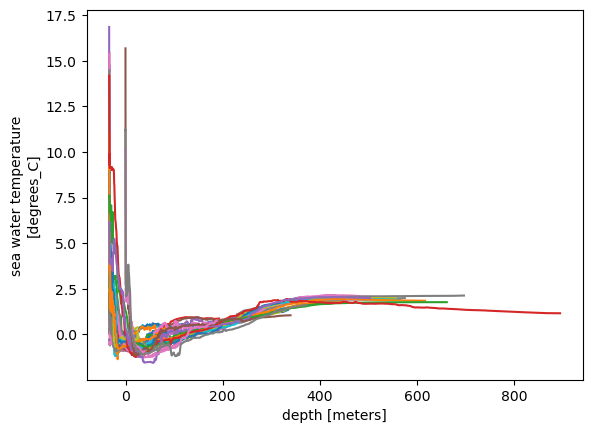

In [5]:
## process L2 data to create L1 (remove derived vars)
# loop that takes L2 filenames from 3 directories according to year (2018, 2019, 2020) and then creates L1 netCDFs for each file
# output L1 nc files are saved in appropriate folder according to year

dirs = ("F:/PhD_chap3/data/OMG_Narwhals_CTD_data/OMG_Narwhals_CTD_L2/2018/",
        "F:/PhD_chap3/data/OMG_Narwhals_CTD_data/OMG_Narwhals_CTD_L2/2019/",
        "F:/PhD_chap3/data/OMG_Narwhals_CTD_data/OMG_Narwhals_CTD_L2/2020/")

for directory in dirs:
    os.chdir(directory)
    nc_files = []
    for file in glob.glob("*.nc"):
        nc_files.append(file)
    pprint(nc_files)
    
    ## loop to run through L2 files and modify to make L1
    for filename in nc_files:
        data = metadata.loc[metadata['filename_L2'] == filename] # select row for cnv file 'filename'
        file = Path(directory + filename)
        uuid = data.uuid_L1.values[0]
        netcdf_filename = 'OMG_Narwhals_Ocean_CTD_L1_' + filename[26:]
        print(netcdf_filename)
        
        # read in L2 netCDF file
        ctd_data = xr.open_dataset(file)
        ctd_data.close()
        
        ## remove derived variables: salinity, density, pressure, and potential temperature
        ctd_data_L1 = ctd_data.drop(labels = ['salinity', 'density', 'potential_temperature', 'sound_velocity'])
        
        ## change global attributes for L1 dataset
        ctd_data_L1.attrs['title'] = 'OMG Narwhals Ocean CTD Level 1 Data'
        ctd_data_L1.attrs['summary'] = 'This dataset contains conductivity, temperature, and pressure measurements from a ship-deployed CTD instrument. This profile is one of a series of CTD casts from the Oceans Melting Greenland (OMG) Narwhals program. Between August 2018 to August 2020, three bottom-mounted ocean moorings with a suite of instrumentation were deployed at three glacial fronts in Melville Bay: Sverdrup Glacier, Kong Oscar Glacier, and Rink Glacier. During summer cruises where moorings were deployed and/or recovered, full water column CTD profiles were obtained at the glacier fronts and offshore.'
        ctd_data_L1.attrs['keywords'] = 'Conductivity, Water Depth, Water Temperature'
        ctd_data_L1.attrs['id'] = 'OMG_Narwhals_Ocean_CTD_L1'
        ctd_data_L1.attrs['uuid'] = uuid
        ctd_data_L1.attrs['filename'] = netcdf_filename
        ctd_data_L1.attrs['processing_level'] = 'L1'
        
        ## sanity plot
        ctd_data_L1.temperature.plot()
        
        with xr.set_options(display_style="html"):
            display(ctd_data_L1)
        
        ## assign output directory according to sampling year
        if '2018' in netcdf_filename:
            output_dir = Path(directory[:-7] + "1/2018")
        elif '2019' in netcdf_filename:
            output_dir = Path(directory[:-7] + "1/2019")
        elif '2020' in netcdf_filename:
            output_dir = Path(directory[:-7] + "1/2020")
        
        ## save xarray dataset object as netcdf
        netcdf_filename = Path(netcdf_filename)
        ctd_data_L1.to_netcdf(output_dir / netcdf_filename)
        ctd_data_L1.close()

## Check a file

In [6]:
tmp = xr.open_dataset('F:/PhD_chap3/data/OMG_Narwhals_CTD_data/OMG_Narwhals_CTD_L2/2020/OMG_Narwhals_Ocean_CTD_L2_20200809211117.nc')
tmp.close()
tmp

<xarray.Dataset>
Dimensions:                (depth: 6729, profile: 1)
Coordinates:
  * depth                  (depth) float64 -0.109 -0.109 -0.097 ... 339.8 339.8
    latitude               (profile) float64 ...
    longitude              (profile) float64 ...
    start_time             (profile) datetime64[ns] ...
Dimensions without coordinates: profile
Data variables:
    pressure               (depth) float64 ...
    temperature            (depth) float64 ...
    conductivity           (depth) float64 ...
    salinity               (depth) float64 ...
    sound_velocity         (depth) float64 ...
    density                (depth) float64 ...
    potential_temperature  (depth) float64 ...
Attributes: (12/52)
    title:                         OMG Narwhals Ocean CTD Level 2 Data
    summary:                       This dataset contains conductivity, temper...
    Conventions:                   CF-1.8, ACDD-1.3
    keywords:                      Conductivity, Salinity, Water Depth, Water...
    keywords_vocabulary:           NASA Global Change Master Directory (GCMD)...
    standard_name_vocabulary:      NetCDF Climate and Forecast (CF) Metadata ...
    ...                            ...
    geospatial_vertical_min:       -0.132
    geospatial_vertical_max:       339.842
    geospatial_vertical_units:     meters
    geospatial_vertical_positive:  down
    time_coverage_resolution:      P0.25S
    date_created:                  2023-06-30T13:10:42

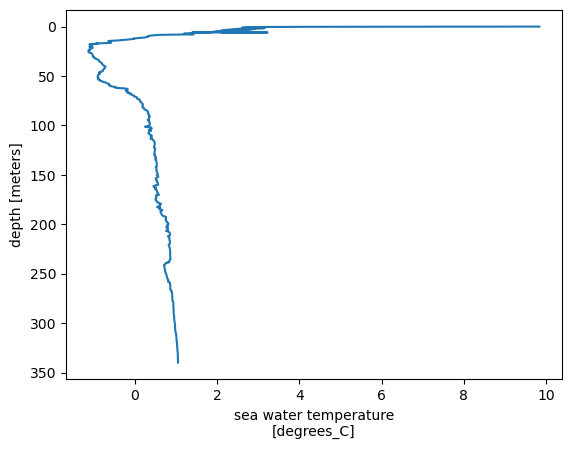

In [7]:
tmp.temperature.where(tmp.depth>0).plot(y='depth')
plt.gca().invert_yaxis()